In [1]:
library('hdp')
library('clusterCrit')
library('grid')
library('gridExtra')
library('ggplot2')
library('ggrepel')
library('RColorBrewer')
library('dplyr')
library('reshape2')
library('IRdisplay')
source('../../../src/tools.R')     # custom tools function
#source('../../../src/hdp_tools.R') # hdp related functions
source('../../../src/hdp_tools_yanis.R')
library(scales)
theme_set(theme_minimal())

# set jupyer notebook parameters
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 200, # set the maximum number of rows displayed
        repr.matrix.max.cols = 200) # set the maximum number of columns displayed

Run citation('hdp') for citation instructions,
    and file.show(system.file('LICENSE', package='hdp')) for license details.

Attaching package: ‘dplyr’

The following object is masked from ‘package:gridExtra’:

    combine

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
### Tools to get max and second max proba with corresponding components

add_first_second_predicted_component <- function(hdp_output, data) {
    # Return a dataframe giving for each patient the probability by component, as well as the assigned component and its probability (max_proba)
    # → Arguments
    #     - hdp_output: hdpSampleChain or hdpSampleMulti object
    #     - data      : original data

    # keep all DP but first (first level)
    dd_predicted <- data.frame(comp_dp_distn(hdp_output)$mean[-1,])

# change categories colnames
    colnames(dd_predicted) <- paste0('component_', 0:(ncol(dd_predicted)-1))
    components_colnames <- colnames(dd_predicted)

    # pprint various info
    print_and_flush(sprintf('Number of components: %d\n', ncol(dd_predicted) - 1))
    print_and_flush(sprintf('Number of NA rows   : %d\n', nrow(dd_predicted[rowSums(is.na(dd_predicted)) != 0,])))

    # evaluate for each row the predicted component
    dd_predicted['initial_predicted_component'] <- apply(dd_predicted, 1, function(x) { if (all(is.na(x)))
                                                                     return(NaN)
                                                                 else
                                                                     return(which.max(x)-1)
                                                                })
    dd_predicted[, 'initial_predicted_component'] <- factor(dd_predicted[, 'initial_predicted_component'])


    dd_predicted['second_predicted_component'] <- apply(dd_predicted[,components_colnames], 1, function(x) { if (all(is.na(x)))
                                                                     return(NaN)
                                                                 else
                                                                     tmp <- names(which.max(x[x!=max(x)]))
                                                                     return(as.numeric(substr(tmp,nchar(tmp),nchar(tmp))))
                                                                })
    dd_predicted[, 'second_predicted_component'] <- factor(dd_predicted[, 'second_predicted_component'])
    
    # evaluate for each row the maximum probability associated to the predicted component
    
    dd_predicted['max_proba'] <- apply(dd_predicted[,components_colnames], 1, function(x) { if (all(is.na(x)))
                                                                                  return(NaN)
                                                                              else
                                                                                 return(max(x))
                                                                            })

    dd_predicted['second_max_proba'] <- apply(dd_predicted[,components_colnames], 1, function(x) { if (all(is.na(x)))
                                                                                  return(NaN)
                                                                              else
                                                                                 return(max(x[x!=max(x)]))
                                                                            })

    return (dd_predicted)
}

In [3]:
### Tools to launch HDP and get results

launch <- function(data,base_dist,initial_clusters,burn,posterior_samples,chains,aa,ab){
    number_of_chains <- chains
    chain_list <- vector('list', number_of_chains)
    hdp <- initialise_hdp_yanis(data = data,hh=base_dist,alphaa = aa,alphab= ab)


    for (i in 1:number_of_chains) {
        seed <- i * 100
        print_and_flush(sprintf('### Experiment %d (seed = %d) ###\n', i, seed))

        # run single hdp chain
        chain_list[[i]] <- activate_and_run_hdp(hdp,
                                                initcc = initial_clusters,
                                                burnin = burn,
                                                n      = posterior_samples,
                                                space  = 20,
                                                seed   = seed)
        print_and_flush('\n')
    }

    multi_output <- hdp_multi_chain(chain_list)
    print(multi_output)
}

In [6]:
df_final <- read.table("modif_final.tsv")
100*colSums(df_final)/2150

ASXL1           ASXL2           ASXL3            ATRX           BAGE3 
     7.90697674      1.81395349      0.09302326      0.46511628      0.51162791 
           BCOR            BRAF            CBFB             CBL          CDKN2A 
     4.51162791      0.37209302      0.18604651      2.09302326      0.13953488 
       CEBPA_bi      CEBPA_mono           CNTN5          CREBBP           CSF1R 
     2.46511628      5.06976744      0.04651163      0.27906977      0.04651163 
          CSF3R            CTCF            CUL2            CUX1          DNMT3A 
     1.48837209      0.83720930      0.04651163      1.30232558     27.39534884 
            EED            ETV6            EZH2           FBXW7             ITD 
     0.27906977      1.34883721      4.00000000      1.44186047     21.20930233 
       FLT3_TKD      FLT3_other           GATA1           GATA2            GNAS 
     9.25581395      4.41860465      0.41860465      3.95348837      0.32558140 
           GNB1            IDH1     IDH2_p.R140     IDH2_p.R172            JAK2 
     0.18604651      6.69767442     11.25581395      2.79069767      1.67441860 
           JAK3          KANSL1           KDM6A             KIT           KMT2C 
     0.46511628      0.69767442      0.65116279      4.00000000      0.51162791 
          KMT2D           KMT2E            KRAS          LUC7L2           MED12 
     0.93023256      0.74418605      5.39534884      0.37209302      0.74418605 
            MLL             MPL             MYC             NF1            NFE2 
     5.67441860      0.74418605      2.04651163      3.48837209      0.41860465 
         NOTCH1            NPM1      NRAS_other   NRAS_p.G12_13   NRAS_p.Q61_62 
     0.55813953     31.72093023      0.27906977     11.81395349      3.86046512 
          PDS5B            PHF6          PPFIA2           PRPF8            PTEN 
     0.09302326      2.97674419      0.09302326      0.74418605      0.04651163 
         PTPN11           PTPRF           PTPRT           RAD21            RIT1 
     8.00000000      0.09302326      0.04651163      3.81395349      1.58139535 
          RUNX1           S100B          SETBP1             SF1           SF3B1 
    14.79069767      0.04651163      2.00000000      0.23255814      3.02325581 
          SMC1A            SMC3            SMG1            SPP1           SRSF2 
     2.55813953      2.27906977      0.13953488      0.04651163     14.23255814 
          STAG2          STAT5B           SUZ12            TET2            TP53 
     6.13953488      0.27906977      0.27906977     18.09302326      8.00000000 
          U2AF1             WT1           ZRSR2           add_8          add_11 
     4.97674419      6.69767442      0.97674419      9.95348837      3.76744186 
         add_13          add_21          add_22          del_20           del_3 
     2.23255814      3.72093023      2.69767442      2.74418605      2.13953488 
          del_5           del_7           del_9          del_12          del_13 
     6.88372093      8.65116279      3.02325581      2.60465116      2.04651163 
         del_16          del_17          del_18          minusy          t_v_11 
     2.27906977      3.44186047      2.60465116      3.44186047      2.97674419 
        t_10_21         t_12_13         t_12_17         t_12_22         t_13_19 
     0.09302326      0.09302326      0.13953488      0.27906977      0.09302326 
        t_15_16         t_15_17         t_16_17         t_16_21         t_17_19 
     0.09302326      0.97674419      0.23255814      0.09302326      0.13953488 
        t_17_21          t_1_12          t_1_14          t_1_16          t_1_17 
     0.13953488      0.09302326      0.09302326      0.18604651      0.13953488 
         t_1_19           t_1_3           t_1_4           t_1_5           t_1_6 
     0.09302326      0.13953488      0.18604651      0.09302326      0.09302326 
         t_2_17           t_2_3           t_2_5           t_2_7           t_2_9 
     0.13953488      0.09302326      0.09

In [5]:
table(df_final$inv_3)


   0    1 
2128   22 

In [6]:
### Tools for distributions of HDP


num_cols = ncol(df_final)
bin <- function(x){
    set.seed(123)
  (rbinom(1, num_cols, mean(x))+1)/num_cols
}

###Normal

normal <- function(x){
    set.seed(123)
  abs(rnorm(1,mean(x),sd(x)))
}

###Poisson

poisson <- function(x){
    set.seed(123)
  (rpois(num_cols,1))/num_cols
}

###Uniform equally over all columns

equally <- function(x){
    set.seed(123)
  1/num_cols
}

###Repet 1

repet <- function(x){
    set.seed(123)
  1
}

binomial <- unlist(sapply(df_final,bin))
gaussian <- unlist(sapply(df_final,normal))
pois <- as.numeric(unlist(sapply(df_final,poisson)))
unif <- unlist(sapply(df_final,equally))
repetition <- unlist(sapply(df_final,repet))
lists<- list(binomial,gaussian,unif,repetition)


# I) Initial Component : Component 0 to 10

In [7]:
data <- df_final
posterior_samples <- 250
initial_clusters <- 17
burn <- 7000
chains <- 3
base_dist <- gaussian
aa <- 0.5
ab <-1.5

Initialise HDP on a 2150 x 153 dataframe
  → create HDP structure... done!
  → add DP node for each patient... done!
  → assign the data to the nodes... done!
### Experiment 1 (seed = 100) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "7000 burn-in iterations in 0.4 mins"

### Experiment 2 (seed = 200) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "7000 burn-in iterations in 0.4 mins"

### Experiment 3 (seed = 300) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "7000 burn-in iterations in 0.4 mins"

Object of class hdpSampleMulti 
 Number of chains: 3 
 Total posterior samples: 750 
 Components: NO. Run hdp_extract_components 
 ----------
 Final hdpState from first chain: 
Object of class hdpState 
 Number of DP nodes: 2151 
 Index of parent DP: 0 1 1 1 1 1 1 1 1 1 ...
 Number of 

,values,count,freq
2,1,833,38.7441860465116
3,2,418,19.4418604651163
4,3,229,10.6511627906977
5,4,128,5.95348837209302
6,5,114,5.30232558139535
7,6,114,5.30232558139535
1,0,96,4.46511627906977
9,8,61,2.83720930232558
12,NaN,51,2.37209302325581
8,7,50,2.32558139534884


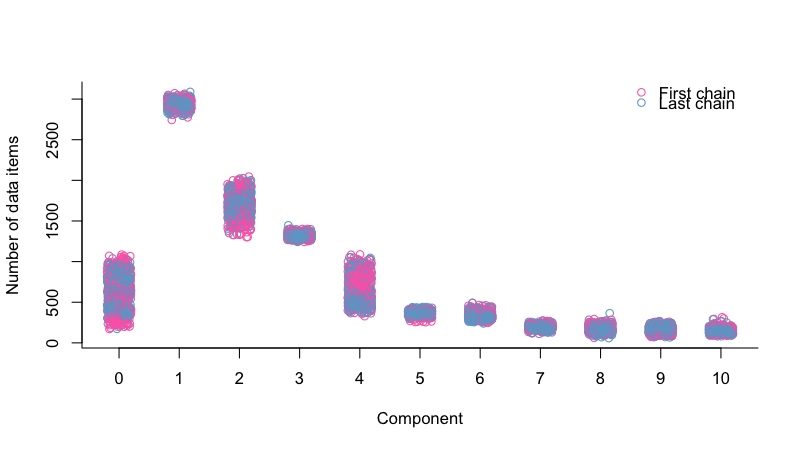

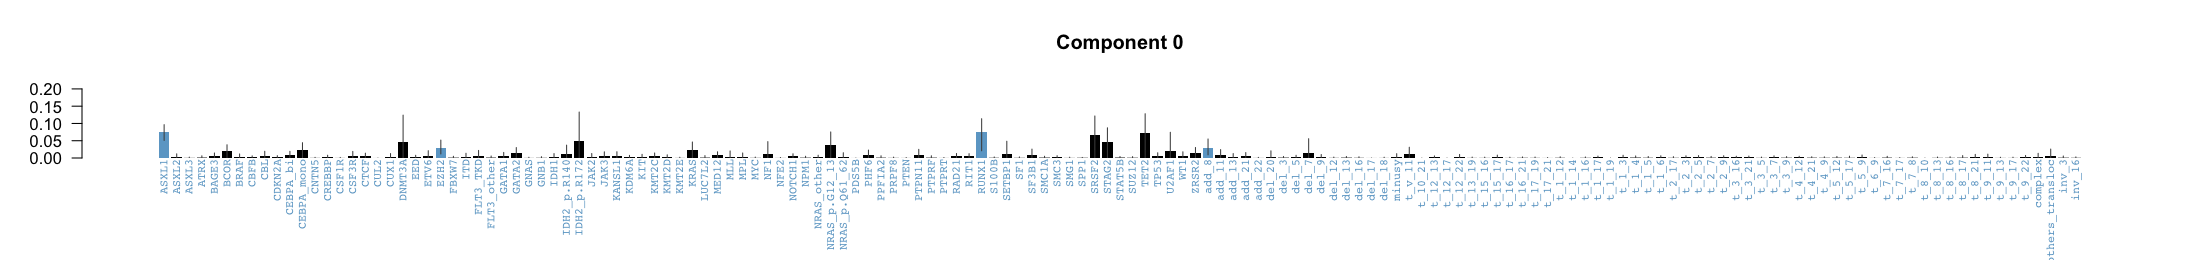

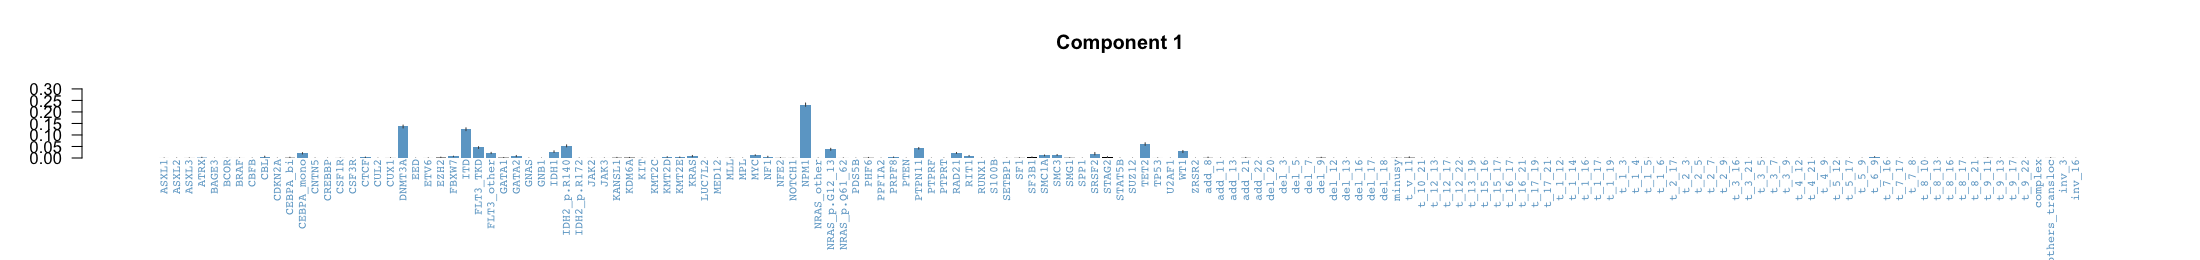

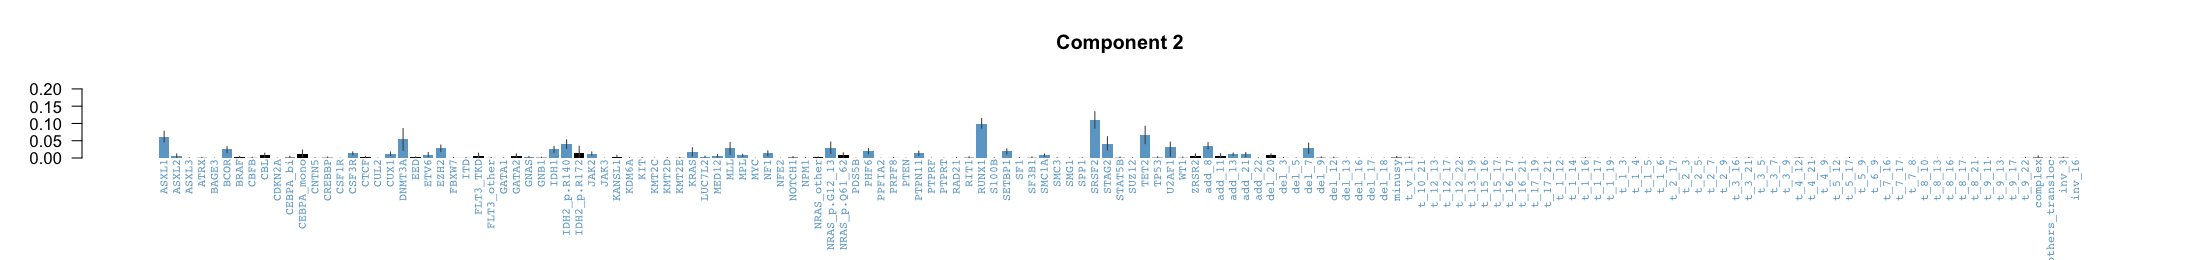

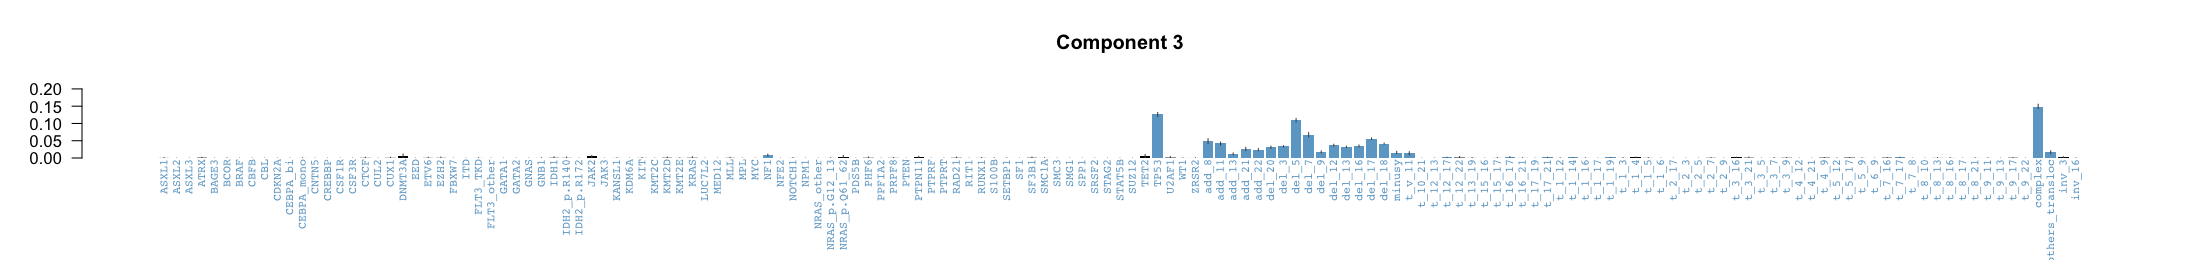

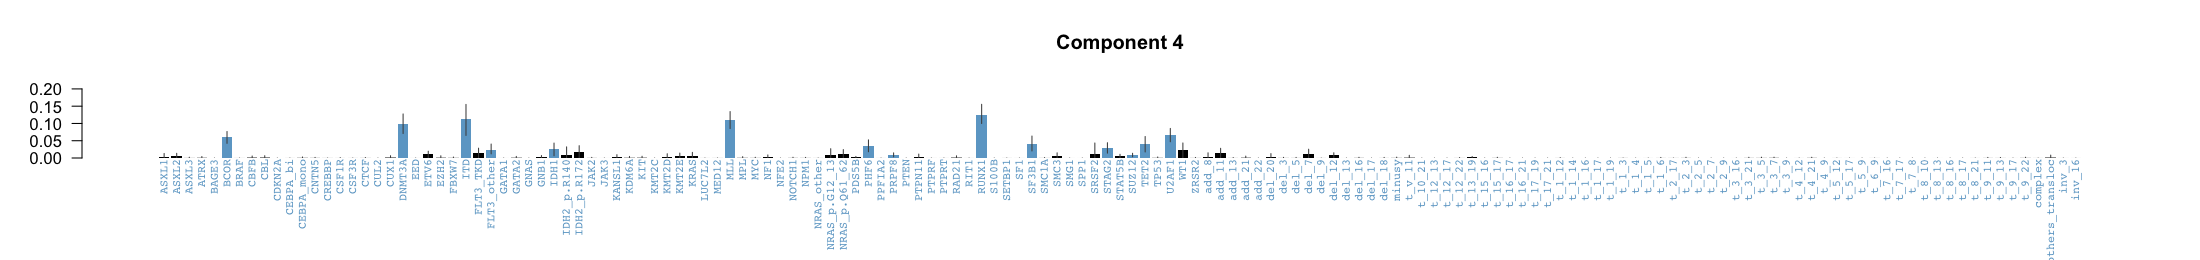

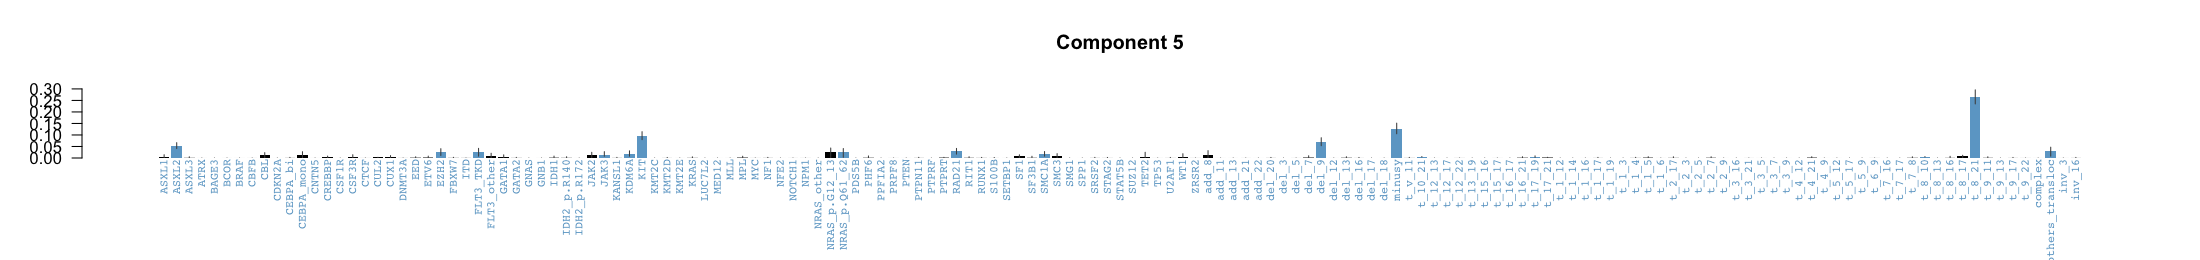

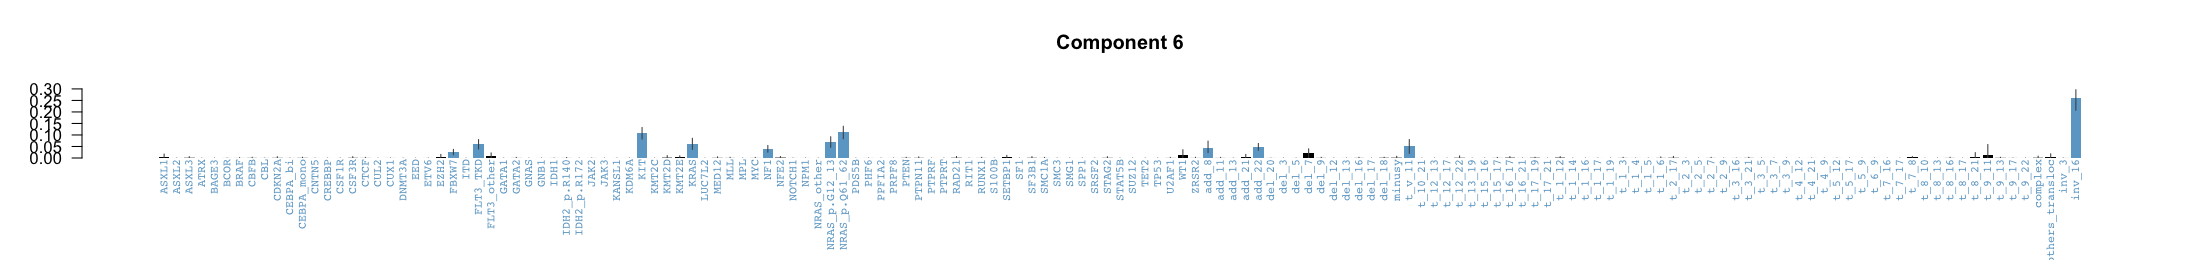

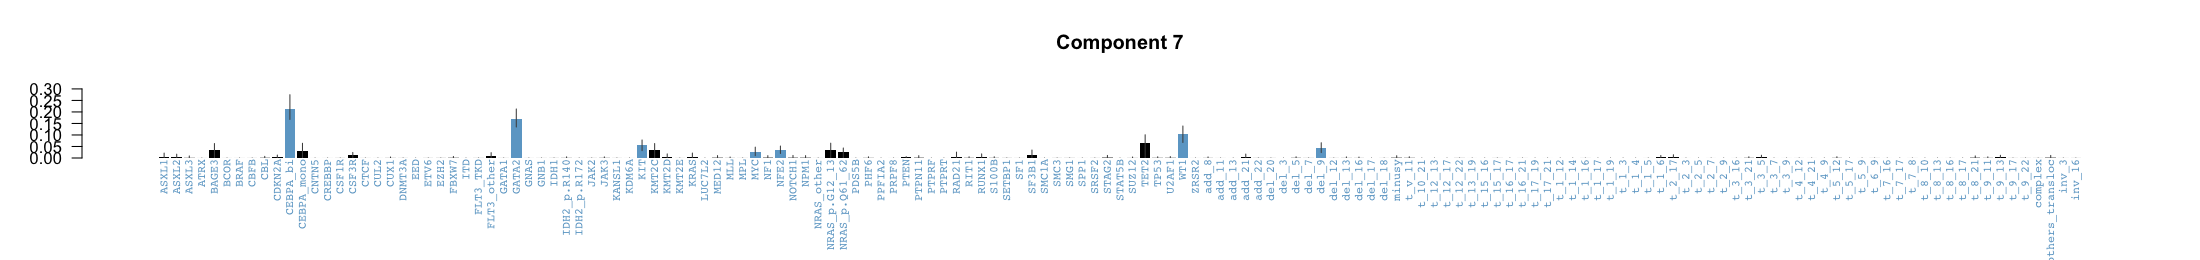

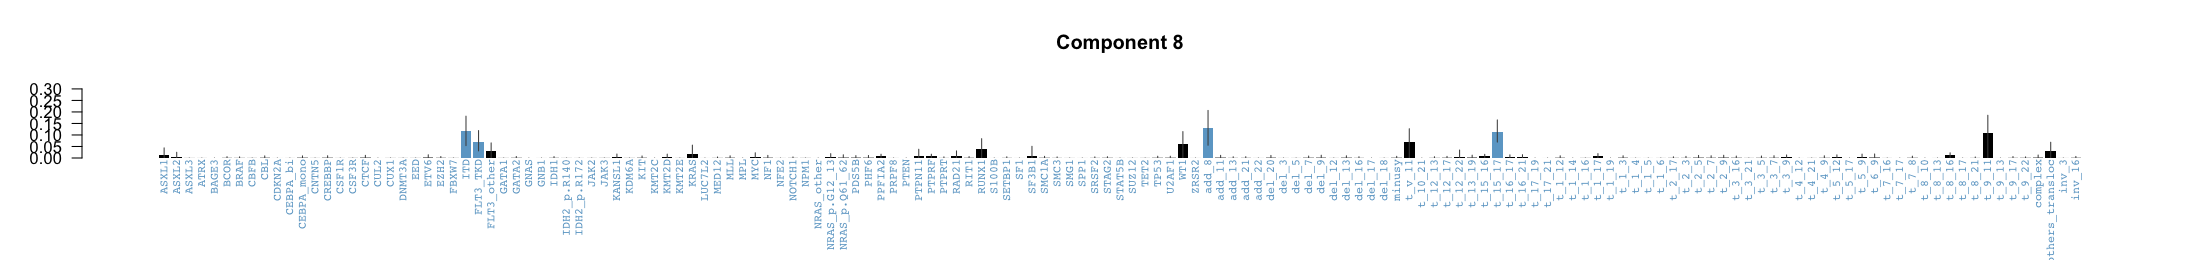

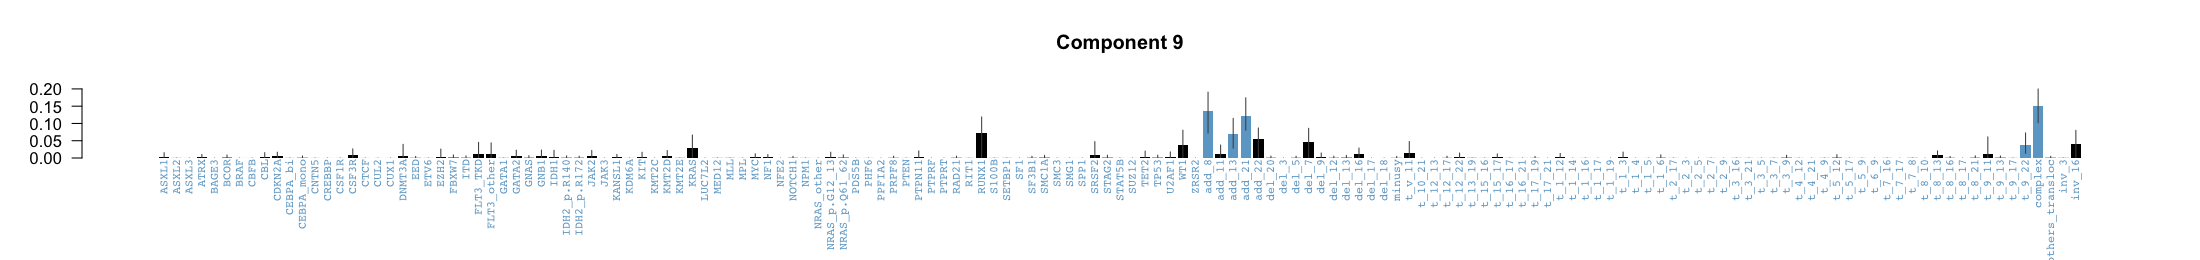

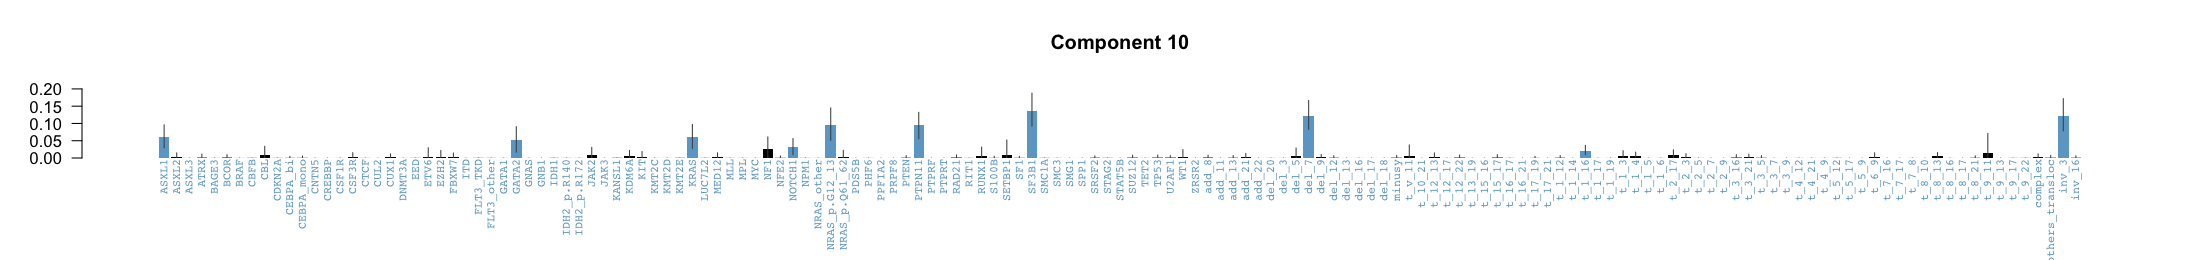

In [8]:

multi_output <- launch(data,base_dist,initial_clusters,burn,posterior_samples,chains,aa,ab)
multi_output_cluster_10 <- extract_components(multi_output)

# get table
dd_predicted_10_components <- get_prediction_result_dataframe(multi_output_cluster_10, df_final)
tab <- get_table(dd_predicted_10_components[,'predicted_component'])
tab


#plot components
plot_components_size(multi_output_cluster_10,8,4.5)
set_notebook_plot_size(22, 2.6)
plot_comp_distn(multi_output_cluster_10,
                cat_names  = colnames(df_final),
                col        = "skyblue3",
                col_nonsig = "black",
                                     )



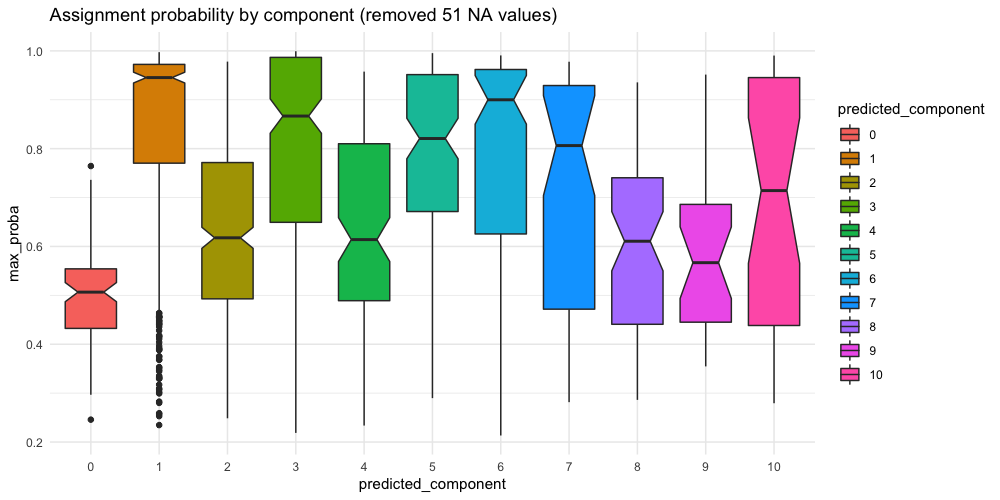

In [9]:
plot_assignement_probability_by_component(dd_predicted_10_components)

In [10]:
initial_components <- cbind(df_final,add_first_second_predicted_component(multi_output_cluster_10))
sum(rowSums(initial_components[initial_components$predicted_component=="NaN",1:151]))
#initial_components <- na.omit(initial_components)

Number of components: 10
Number of NA rows   : 51


[1] 0

In [11]:
#write.table(initial_components,file="initial_components_with_proba.tsv",sep='\t')
#write.table(initial_components,file="initial_components_with_proba_and_na.tsv",sep='\t')

# STEP 1: DEFINING FEATURE IN EACH COMPONENT

In [12]:
tmp <- read.table("initial_components_with_proba.tsv")
tmp <- read.table("initial_components_with_proba_and_na.tsv")
tmp$initial_refined_component <- "not_assigned"

tmp[tmp$NPM1==1,]$initial_refined_component <- "NPM1"

tmp[tmp$initial_refined_component=="not_assigned" & (tmp$TP53==1 & tmp$complex==1),]$initial_refined_component <- "TP53_complex"

tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==3 & (tmp$TP53==1 | tmp$complex==1),]$initial_refined_component <- "TP53_complex"

tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==5 & tmp$t_8_21==1,]$initial_refined_component <- "t_8_21"

tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==6 & tmp$inv_16==1,]$initial_refined_component <- "inv_16"

tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==7 & tmp$CEBPA_bi==1,]$initial_refined_component <- "CEBPA_bi"

tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==8 & (tmp$t_v_11==1 | tmp$t_9_11==1),]$initial_refined_component <- "t_11"
tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==8 & tmp$t_15_17==1,]$initial_refined_component <- "t_15_17"

tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==9 & (tmp$add_8==1 | tmp$add_13==1 | tmp$add_21==1 | tmp$add_22==1),]$initial_refined_component <- "additions"

tmp[tmp$initial_refined_component=="not_assigned" & tmp$initial_predicted_component==10 & tmp$inv_3==1,]$initial_refined_component <- "inv_3"

tmp[is.na(tmp$max_proba),]$initial_refined_component <- "no_events"

In [13]:
table(tmp$initial_refined_component)


   additions     CEBPA_bi       inv_16        inv_3    no_events not_assigned 
          21           35           85           13           51          915 
        NPM1         t_11      t_15_17       t_8_21 TP53_complex 
         682           31           19           99          199 

In [14]:
# Patients that did not pass the first test (not defining feature of their component)
table(tmp[tmp$initial_refined_component=="not_assigned" & !is.element(tmp$initial_predicted_component,c(0,2,4)),]$initial_predicted_component)
cat("Number of patients for second max proba in HDP 1: ", sum(table(tmp[tmp$initial_refined_component=="not_assigned" & !is.element(tmp$initial_predicted_component,c(0,2,4)),]$initial_predicted_component)))


  1   3   5   6   7   8   9  10 
160  32  14  29  14  11   5  16 

Number of patients for second max proba in HDP 1:  281

# STEP 2: SECOND MAX PROBA WITH DEFINING FEATURES

In [15]:
### Get Min Proba for each component
min_proba_NPM1 = min(tmp[tmp$initial_predicted_component==1,]$max_proba,na.rm=T)

min_proba_TP53_complex = min(tmp[tmp$initial_predicted_component==3,]$max_proba,na.rm=T)

min_proba_t_8_21 = min(tmp[tmp$initial_predicted_component==5,]$max_proba,na.rm=T)

min_proba_inv_16 = min(tmp[tmp$initial_predicted_component==6,]$max_proba,na.rm=T)

min_proba_CEBPA_bi = min(tmp[tmp$initial_predicted_component==7,]$max_proba,na.rm=T)

min_proba_transloc = min(tmp[tmp$initial_predicted_component==8,]$max_proba,na.rm=T)

min_proba_additions = min(tmp[tmp$initial_predicted_component==9,]$max_proba,na.rm=T)

min_proba_inv_3 = min(tmp[tmp$initial_predicted_component==10,]$max_proba,na.rm=T)

In [16]:
## Refine patients with second max proba.

tmp[tmp$initial_refined_component=="not_assigned"  ,]$initial_refined_component  <- apply(tmp[tmp$initial_refined_component=="not_assigned" ,], 1,function(x) {
        if (all(is.na(x['second_predicted_component'])))
            return(NaN)
        else 
            return(ifelse(x['second_predicted_component']==3 & x['second_max_proba']>=0.75*min_proba_TP53_complex & (x['complex']==1 | x["TP53"]==1),"TP53_complex",
                          
                   ifelse(x['second_predicted_component']==5 & x['second_max_proba']>=0.75*min_proba_t_8_21 & x['t_8_21']==1 ,"t_8_21",
                          
                   ifelse(x['second_predicted_component']==6 & x['second_max_proba']>=0.75*min_proba_inv_16 & x['inv_16']==1,"inv_16", 
                          
                   ifelse(x['second_predicted_component']==7  & x['second_max_proba']>=0.75*min_proba_CEBPA_bi & x['CEBPA_bi']==1,"CEBPA_bi", 
                          
                   ifelse(x['second_predicted_component']==8 & x['second_max_proba']>=0.75*min_proba_transloc & (x['t_v_11']==1 | x['t_9_11']==1),"t_11",
                   ifelse(x['second_predicted_component']==8 & x['second_max_proba']>=0.75*min_proba_transloc & x['t_15_17']==1 ,"t_15_17",
                          
                   ifelse(x['second_predicted_component']==9 & x['second_max_proba']>=0.75*min_proba_additions & (x['add_8']==1 | x['add_13']==1 | x['add_21']==1 | x['add_22']==1 ),"additions",
                          
                   ifelse(x['second_predicted_component']==10 & x['second_max_proba']>=0.75*min_proba_inv_3 & x['inv_3']==1,"inv_3",       
                   "not_assigned")))))))))
    })
table(tmp$initial_refined_component)


   additions     CEBPA_bi       inv_16        inv_3    no_events not_assigned 
          24           39           88           13           51          888 
        NPM1         t_11      t_15_17       t_8_21 TP53_complex 
         682           41           20           99          205 

# Let's reapply HDP to patients from Initial Component 0,2,4 + patients that do not have defining features from their component and that were not assigned with second max proba 

### (642 from C 0,2,4 -6 NPM1 -2 TP53-complex  =634  and 260 unassigned ) Total :894 patients

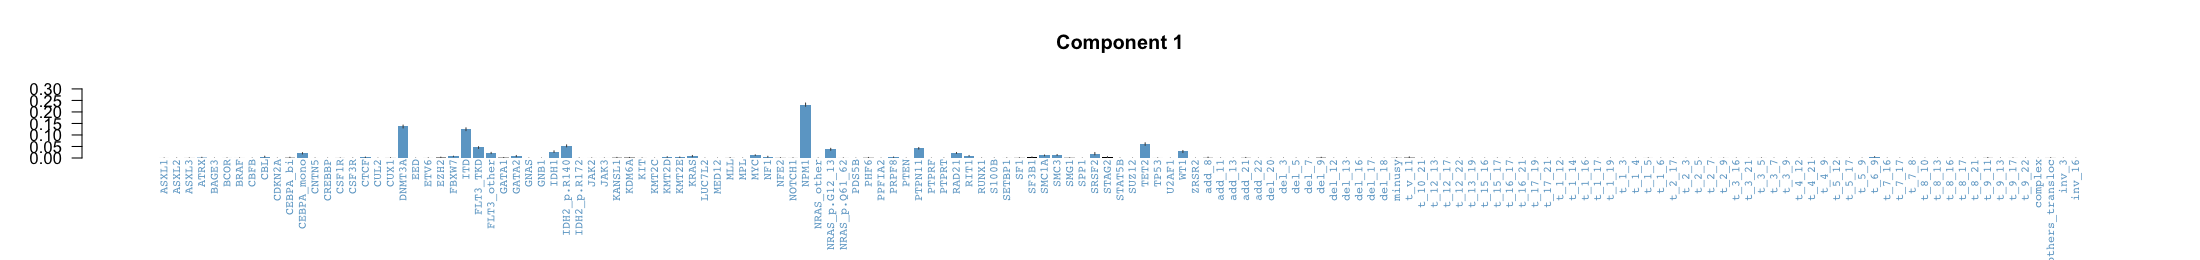

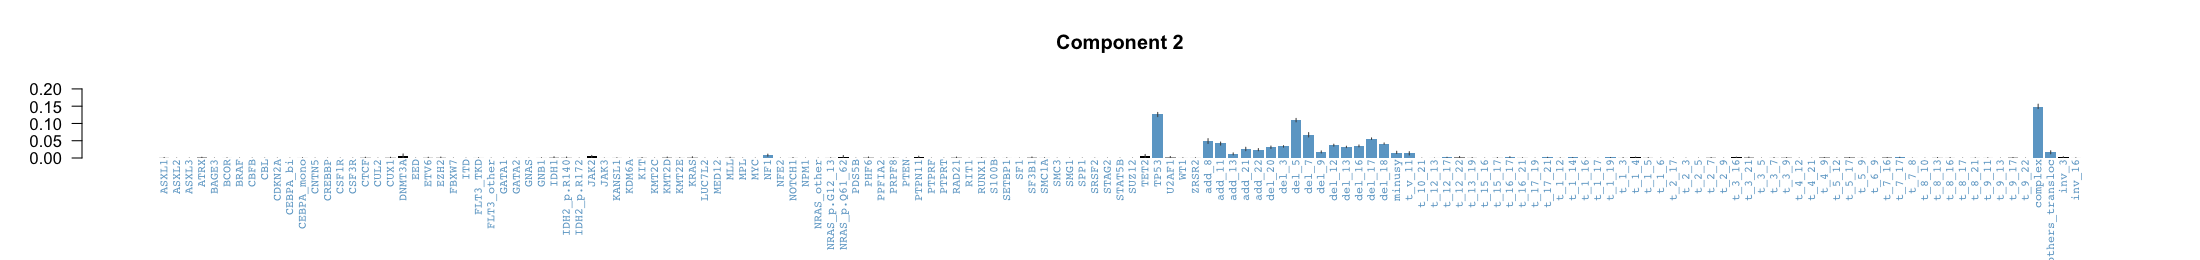

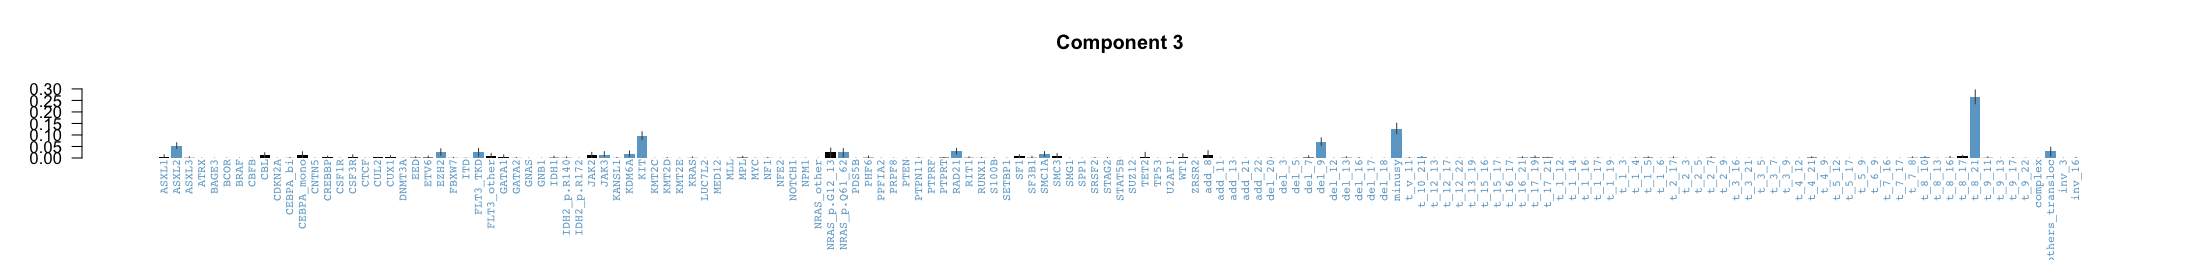

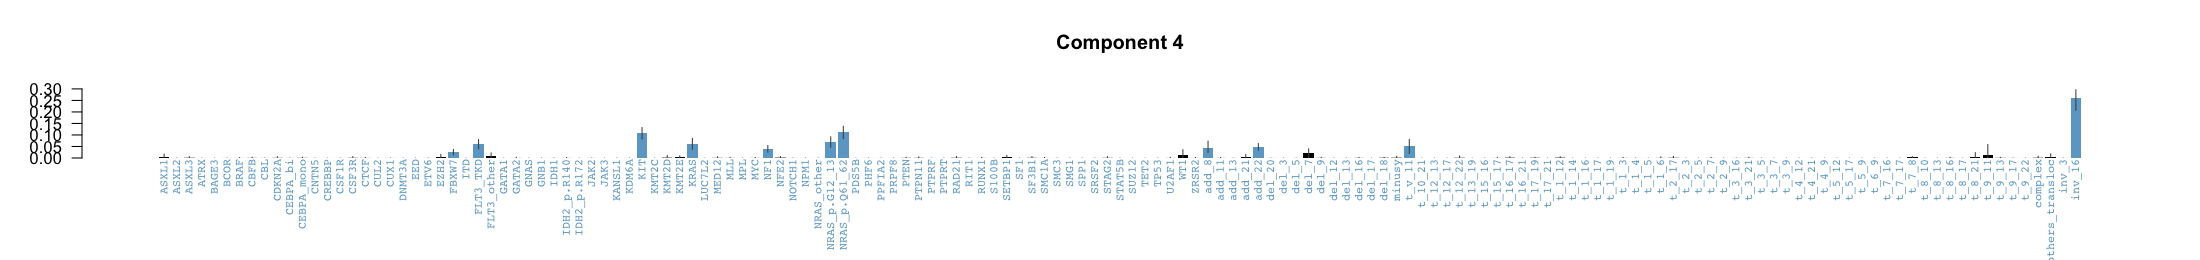

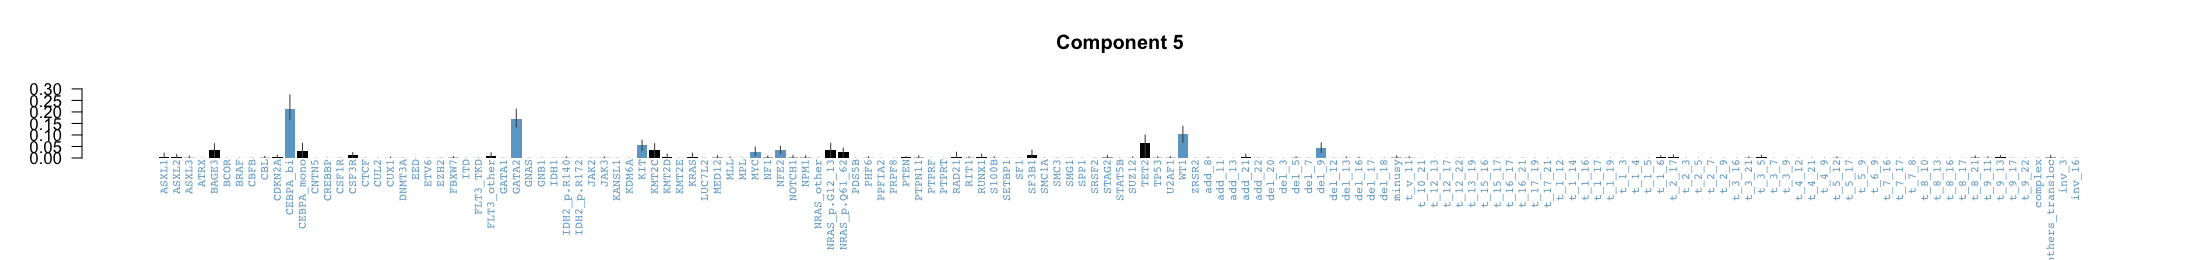

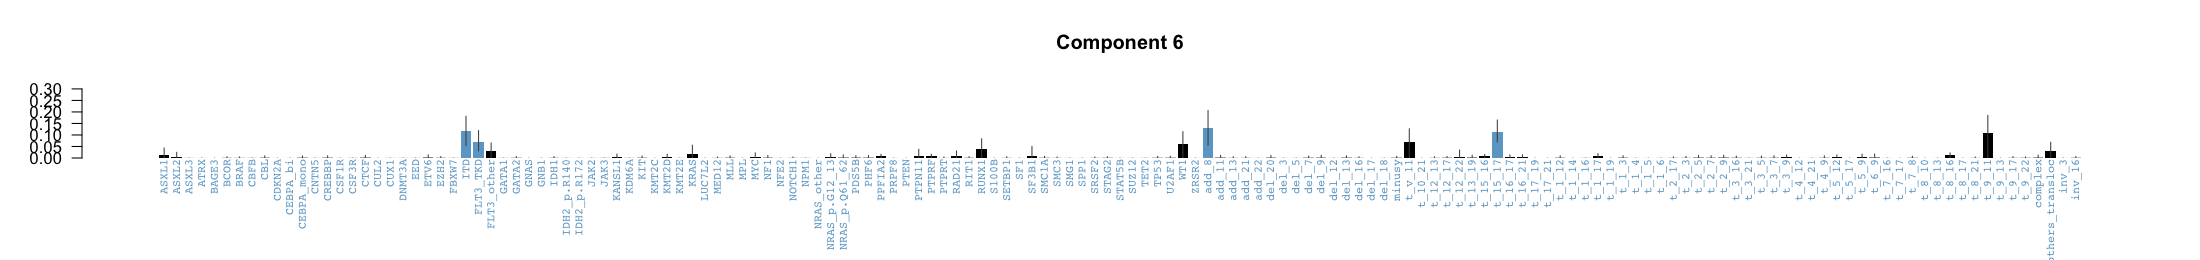

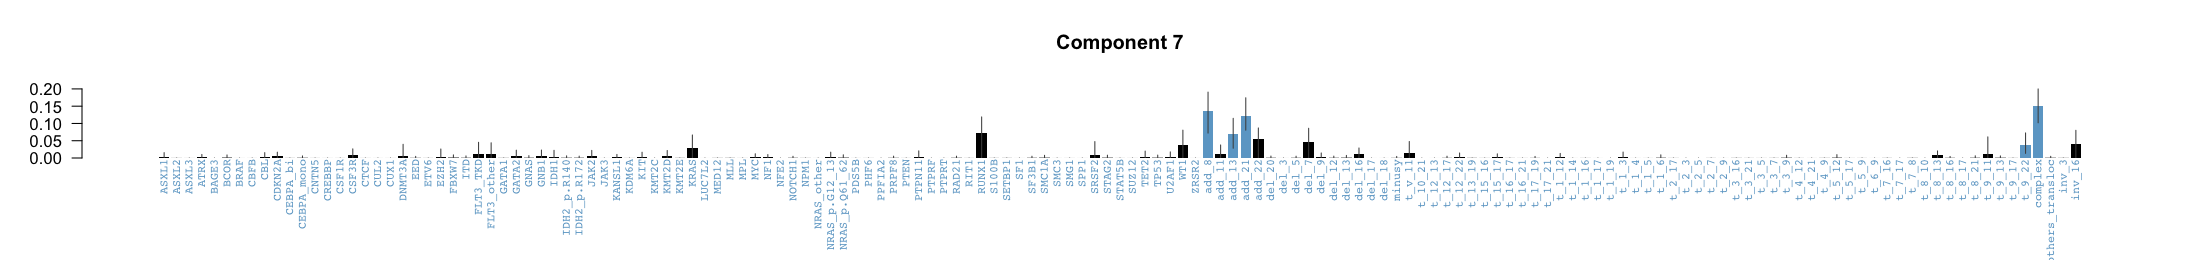

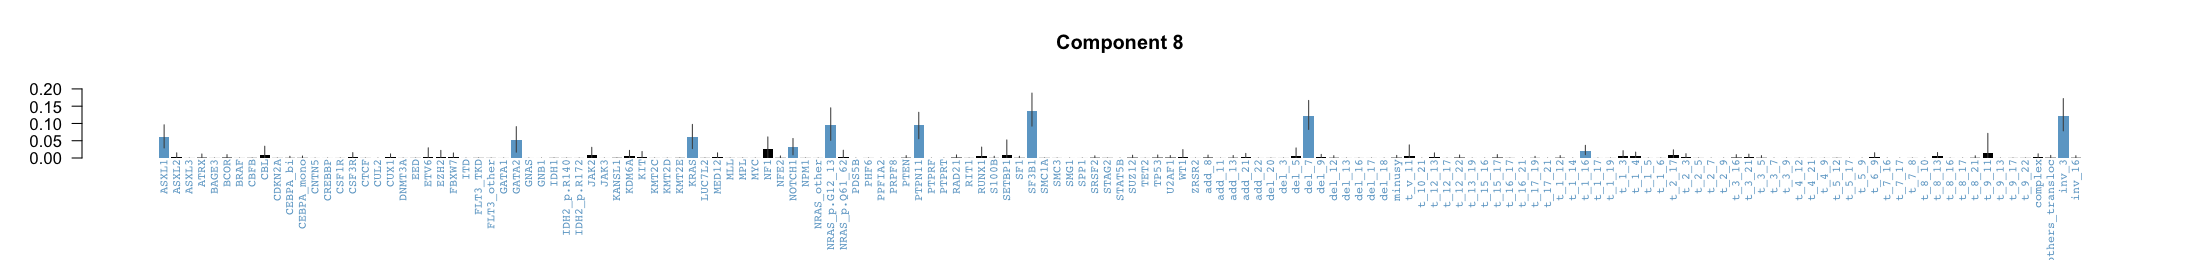

In [17]:
set_notebook_plot_size(22, 2.6)
    plot_comp_distn(multi_output_cluster_10,
                    cat_names  = colnames(df_final),
                    col        = "skyblue3",
                    col_nonsig = "black",
                    comp=c(1,3,5,6,7,8,9,10),
                    plot_title=c("Component 1","Component 2","Component 3","Component 4","Component 5","Component 6","Component 7","Component 8")
                                         )

# II- HDP reapplied ON THOSE PATIENTS : 888

In [18]:
# All dataframe with U2AF1 separation
df <- read.table("../../../data/initial_dataset/1013.mut.csv",sep=',', header = T)
df <- df[df$gene=="U2AF1",c("data_pd","gene","protein")]
df$U2AF1_p.S34 <- ifelse(grepl( "34",df$protein) | grepl( "35",df$protein),1,0)
df$U2AF1_p.Q157 <- ifelse(grepl( "157",df$protein) | grepl( "156",df$protein),1,0)
df <- unique(df,by="data_pd")
newd <-  df %>% group_by(data_pd) %>% filter(n()>1)
tmp1 <- data.frame(data_pd=unique(newd$data_pd),gene=rep("U2AF1",length(unique(newd$data_pd))),protein=rep("p",length(unique(newd$data_pd))),U2AF1_p.S34=rep(0,length(unique(newd$data_pd))),U2AF1_p.Q157=rep(0,length(unique(newd$data_pd))))
for (element in unique(newd$data_pd)){    
    tmp1[tmp1$data_pd==element,]$U2AF1_p.S34 <- colSums(newd[newd$data_pd==element,"U2AF1_p.S34"])
    tmp1[tmp1$data_pd==element,]$U2AF1_p.Q157 <- colSums(newd[newd$data_pd==element,"U2AF1_p.Q157"])
}
df <- rbind(df[!is.element(df$data_pd,unique(newd$data_pd)),c("data_pd","U2AF1_p.S34","U2AF1_p.Q157","protein")],tmp1[,c("data_pd","U2AF1_p.S34","U2AF1_p.Q157","protein")])
rownames(df)<- df$data_pd
df_u2af1 <- df[,c("U2AF1_p.S34","U2AF1_p.Q157")]
tmp_u2af1 <- merge(tmp,df_u2af1,by=0,all.x=T)
rownames(tmp_u2af1) <- tmp_u2af1$Row.names
tmp_u2af1 <- tmp_u2af1[,c(2:81,170,171,83:153,169)]
tmp_u2af1[is.na(tmp_u2af1)] <- 0

In [19]:
df <- read.table("../../../data/initial_dataset/1013.mut.csv",sep=',', header = T)
df <- df[df$gene=="U2AF1",c("data_pd","gene","protein")]
df$U2AF1_p.S34 <- ifelse(grepl( "34",df$protein) | grepl( "35",df$protein),1,0)
df$U2AF1_p.Q157 <- ifelse(grepl( "157",df$protein) | grepl( "156",df$protein),1,0)
df <- unique(df,by="data_pd")
newd <-  df %>% group_by(data_pd) %>% filter(n()>1)
tmp1 <- data.frame(data_pd=unique(newd$data_pd),gene=rep("U2AF1",length(unique(newd$data_pd))),protein=rep("p",length(unique(newd$data_pd))),U2AF1_p.S34=rep(0,length(unique(newd$data_pd))),U2AF1_p.Q157=rep(0,length(unique(newd$data_pd))))
for (element in unique(newd$data_pd)){    
    tmp1[tmp1$data_pd==element,]$U2AF1_p.S34 <- colSums(newd[newd$data_pd==element,"U2AF1_p.S34"])
    tmp1[tmp1$data_pd==element,]$U2AF1_p.Q157 <- colSums(newd[newd$data_pd==element,"U2AF1_p.Q157"])
}
df <- rbind(df[!is.element(df$data_pd,unique(newd$data_pd)),c("data_pd","U2AF1_p.S34","U2AF1_p.Q157","protein")],tmp1[,c("data_pd","U2AF1_p.S34","U2AF1_p.Q157","protein")])
rownames(df)<- df$data_pd
df_u2af1 <- df[,c("U2AF1_p.S34","U2AF1_p.Q157")]
tmp_u2af1 <- merge(tmp,df_u2af1,by=0,all.x=T)
rownames(tmp_u2af1) <- tmp_u2af1$Row.names
tmp_u2af1 <- tmp_u2af1[,c(2:81,171,172,83:154,170)]
tmp_u2af1[is.na(tmp_u2af1)] <- 0

In [20]:
df_to_recluster <- tmp_u2af1[tmp_u2af1$initial_refined_component=="not_assigned",]
df_to_recluster$initial_refined_component <- NULL

In [4]:
#write.table(df_to_recluster,"df_to_recluster.tsv")

In [22]:
num_cols = ncol(df_to_recluster[colSums(df_to_recluster) > 0])  ## keep only column that have at least a mutation
num_cols
bin <- function(x){
    set.seed(123)
  (rbinom(1, num_cols, mean(x))+1)/num_cols
}

###Normal

normal <- function(x){
    set.seed(123)
  abs(rnorm(1,mean(x),sd(x)))
}

###Poisson

poisson <- function(x){
    set.seed(123)
  (rpois(num_cols,1)+1)/num_cols
}

###Uniform equally over all columns

equally <- function(x){
    set.seed(123)
  1/num_cols
}

###Repet 1

repet <- function(x){
    set.seed(123)
  1
}

binomial <- unlist(sapply(df_to_recluster[colSums(df_to_recluster) > 0],bin))
gaussian <- unlist(sapply(df_to_recluster[colSums(df_to_recluster) > 0],normal))
pois <- as.numeric(unlist(sapply(df_to_recluster[colSums(df_to_recluster) > 0],poisson)))
unif <- unlist(sapply(df_to_recluster[colSums(df_to_recluster) > 0],equally))

[1] 129

Initialise HDP on a 888 x 129 dataframe
  → create HDP structure... done!
  → add DP node for each patient... done!
  → assign the data to the nodes... done!
### Experiment 1 (seed = 100) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "5000 burn-in iterations in 0.2 mins"

### Experiment 2 (seed = 200) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "5000 burn-in iterations in 0.2 mins"

### Experiment 3 (seed = 300) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "5000 burn-in iterations in 0.2 mins"

Object of class hdpSampleMulti 
 Number of chains: 3 
 Total posterior samples: 450 
 Components: NO. Run hdp_extract_components 
 ----------
 Final hdpState from first chain: 
Object of class hdpState 
 Number of DP nodes: 889 
 Index of parent DP: 0 1 1 1 1 1 1 1 1 1 ...
 Number of da

,values,count,freq
2,1,319,35.9234234234234
3,2,228,25.6756756756757
1,0,144,16.2162162162162
4,3,101,11.3738738738739
6,5,62,6.98198198198198
5,4,34,3.82882882882883
11,-- total --,888,100%


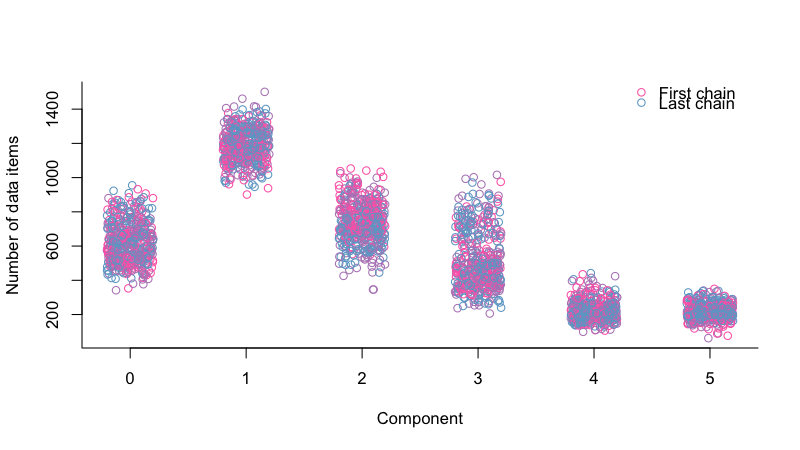

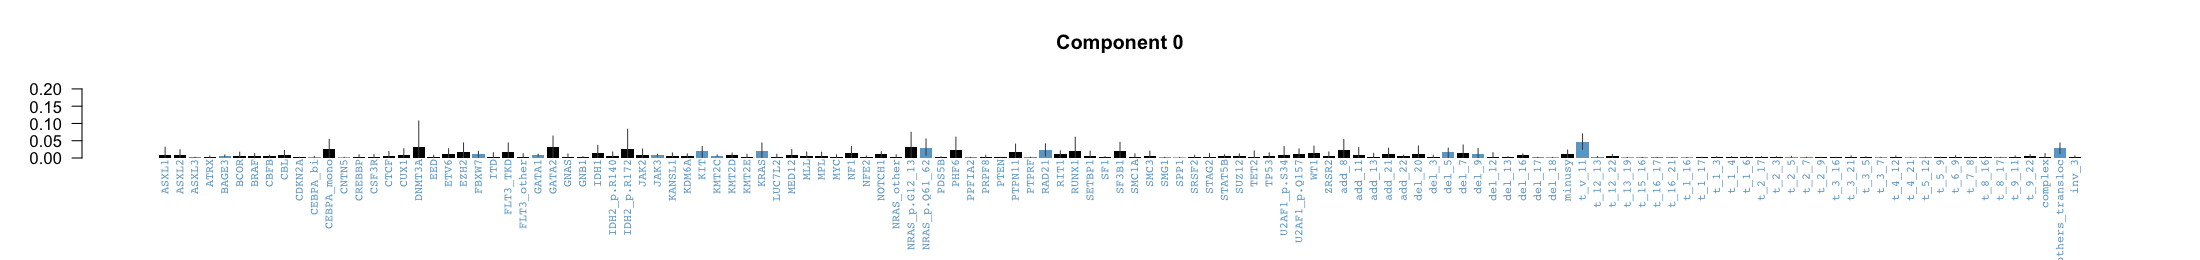

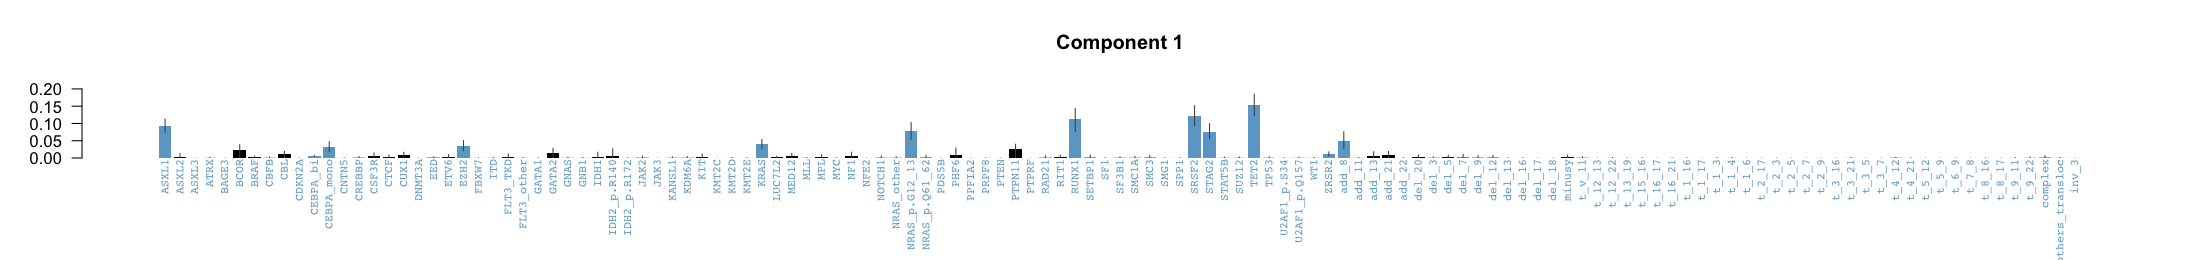

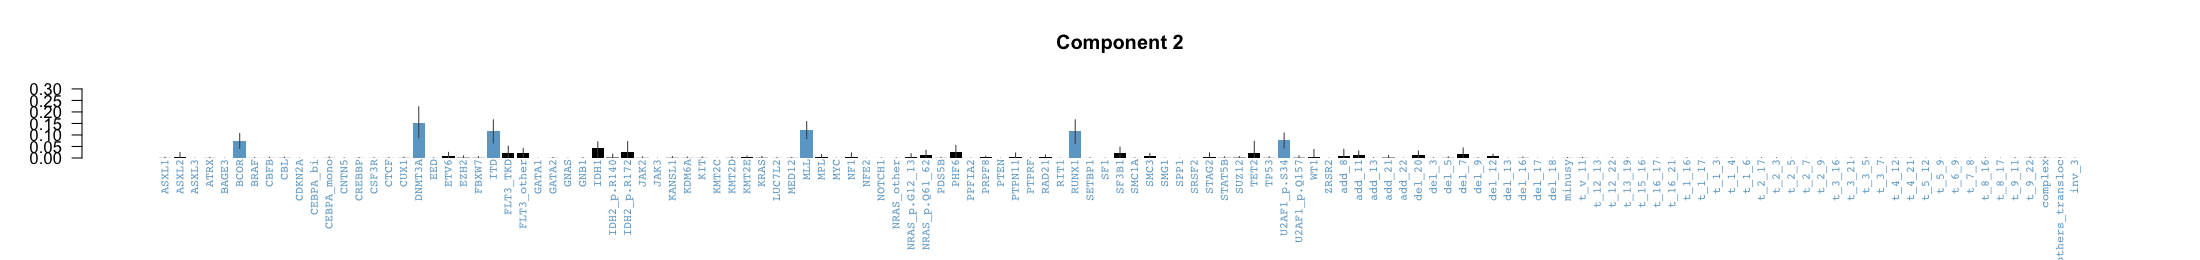

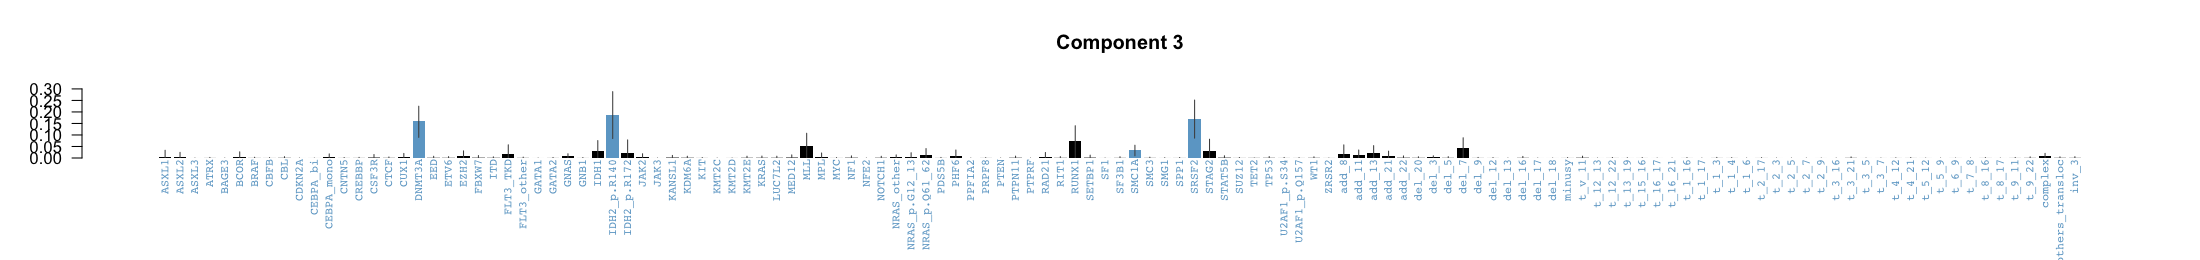

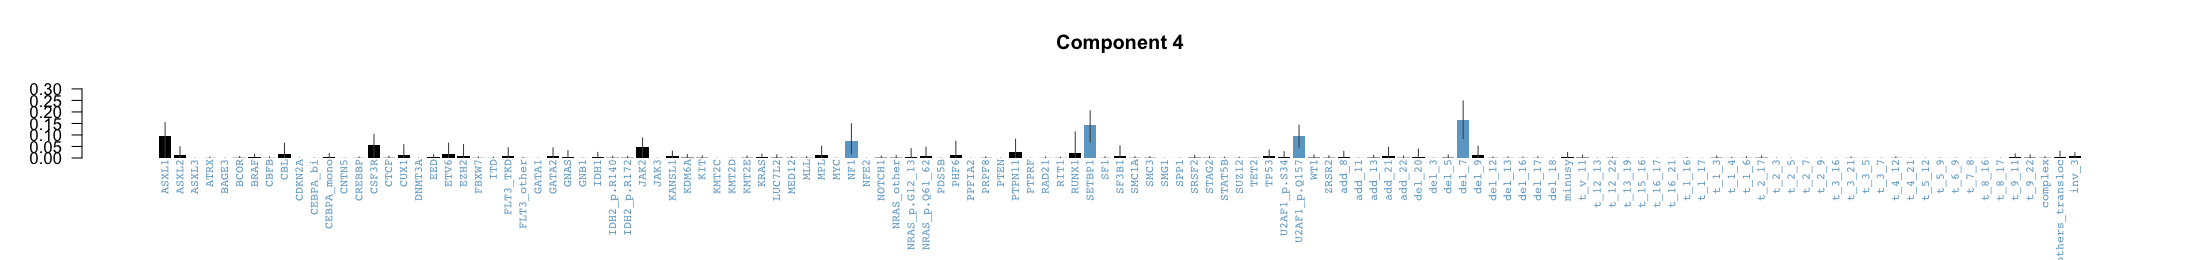

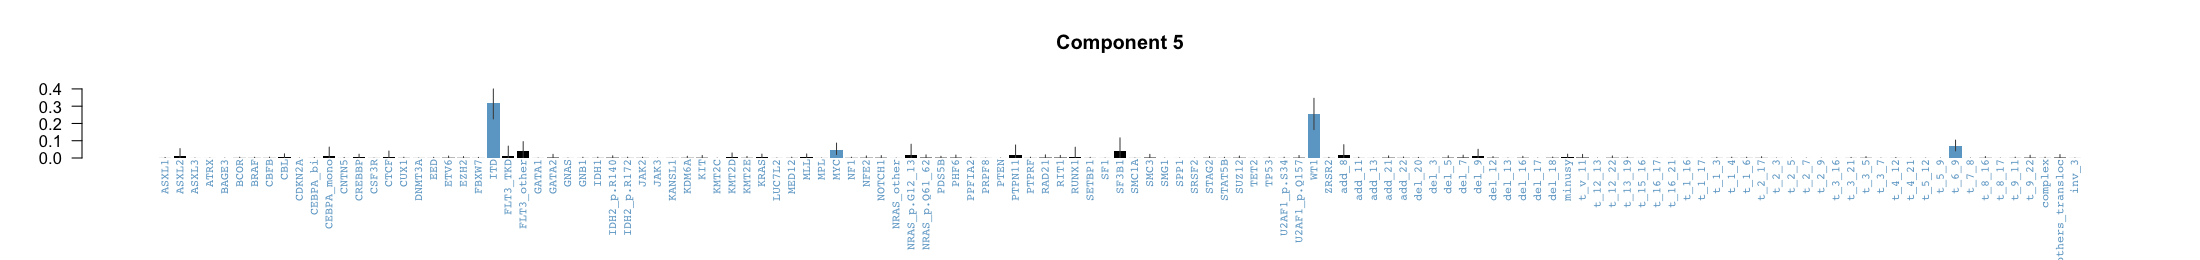

In [23]:
data <- df_to_recluster[colSums(df_to_recluster) > 0]
posterior_samples <- 150
initial_clusters <- 5
burn <- 5000
chains <- 3
base_dist <- gaussian
aa <- 2
ab <-6
multi_output <- launch(df_to_recluster[colSums(df_to_recluster) > 0],base_dist,initial_clusters,burn,posterior_samples,chains,aa,ab)
multi_output_recluster_5 <- extract_components(multi_output)
dd_predicted_5_components <- get_prediction_result_dataframe(multi_output_recluster_5, df_final)
tab <- get_table(dd_predicted_5_components[,'predicted_component'])
tab
plot_components_size(multi_output_recluster_5,8,4.5)
set_notebook_plot_size(22,2.6)
plot_comp_distn(multi_output_recluster_5,
                    cat_names  = colnames(df_to_recluster[colSums(df_to_recluster) > 0]),
                    col        = "skyblue3",
                    col_nonsig = "black")

notch went outside hinges. Try setting notch=FALSE.


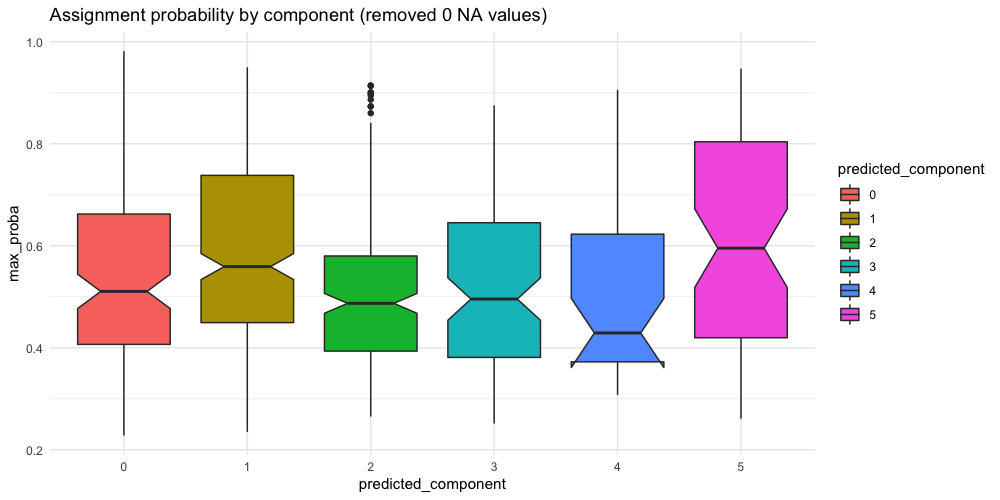

In [24]:
plot_assignement_probability_by_component(dd_predicted_5_components)

# Refining Second HDP with defining features and second max proba

#### High second_hdp_second_max_proba for patients in component 0 so it's a good motivation for reassignment with second max proba!

# STEP 1 Second HDP: DEFINING FEATURES WITHIN COMPONENTS

In [78]:
factors <- c("ZRSR2","U2AF1_p.S34","U2AF1_p.Q157","SRSF2","SF3B1","ASXL1","STAG2","BCOR","RUNX1","EZH2","MLL","PHF6","SF1","NF1","CUX1","SETBP1")
second_hdp_probas <- add_first_second_predicted_component(multi_output_recluster_5)
colnames(second_hdp_probas) <- paste("second_hdp", colnames(second_hdp_probas), sep = "_")  # to not interfer with proba from first HDP
tmp_hdp_2 <- cbind(tmp_u2af1[tmp_u2af1$initial_refined_component=="not_assigned",],second_hdp_probas)
tmp_hdp_2 <- na.omit(tmp_hdp_2)

Number of components: 5
Number of NA rows   : 0


In [79]:
for (comp in c(0,1,2,4)){    
    tmp_hdp_2[tmp_hdp_2$second_hdp_initial_predicted_component==comp & (rowSums(tmp_hdp_2[,factors])>1),"initial_refined_component"] <- "chr_splicing_multiple"
    tmp_hdp_2[tmp_hdp_2$second_hdp_initial_predicted_component==comp & (rowSums(tmp_hdp_2[,factors])==1),"initial_refined_component"] <- "chr_splicing_1"
    }
tmp_hdp_2[tmp_hdp_2$second_hdp_initial_predicted_component==3 & tmp_hdp_2$DNMT3A==1 &(tmp_hdp_2$IDH1==1 | tmp_hdp_2$IDH2_p.R140==1 | tmp_hdp_2$IDH2_p.R172==1) ,]$initial_refined_component <- "DNMT3A_IDH1_2"
tmp_hdp_2[tmp_hdp_2$second_hdp_initial_predicted_component==5 & tmp_hdp_2$t_6_9==1 ,]$initial_refined_component <- "t_6_9"
tmp_hdp_2[tmp_hdp_2$second_hdp_initial_predicted_component==5 & tmp_hdp_2$WT1==1 ,]$initial_refined_component <- "WT1"

In [80]:
t(data.frame(table(tmp_hdp_2$initial_refined_component)))

Var1,chr_splicing_1,chr_splicing_multiple,DNMT3A_IDH1_2,not_assigned,t_6_9,WT1
Freq,170,369,50,247,10,42


# STEP 2 Second HDP: SECOND MAX PROBA + defining lesions

In [81]:
min_proba_chr_splicing = min(min(tmp_hdp_2[tmp_hdp_2$second_hdp_initial_predicted_component==1,]$second_hdp_max_proba),
                             min(tmp_hdp_2[tmp_hdp_2$second_hdp_initial_predicted_component==2,]$second_hdp_max_proba),min(tmp_hdp_2[tmp_hdp_2$second_hdp_initial_predicted_component==4,]$second_hdp_max_proba))

min_proba_DNMT3A_IDH1_2 = min(tmp_hdp_2[tmp_hdp_2$second_hdp_initial_predicted_component==3,]$second_hdp_max_proba)

min_proba_WT1_t_6_9 = min(tmp_hdp_2[tmp_hdp_2$second_hdp_initial_predicted_component==5,]$second_hdp_max_proba)


In [82]:
tmp_hdp_2[tmp_hdp_2$initial_refined_component=="not_assigned" & is.element(tmp_hdp_2$second_hdp_second_predicted_component,c(0,1,2,4))
          & tmp_hdp_2$second_hdp_second_max_proba>=0.75*min_proba_chr_splicing & rowSums(tmp_hdp_2[,factors])>1,]$initial_refined_component <- "chr_splicing_multiple"

tmp_hdp_2[tmp_hdp_2$initial_refined_component=="not_assigned" & is.element(tmp_hdp_2$second_hdp_second_predicted_component,c(0,1,2,4))
          & tmp_hdp_2$second_hdp_second_max_proba>=0.75*min_proba_chr_splicing & rowSums(tmp_hdp_2[,factors])==1,]$initial_refined_component <- "chr_splicing_1"

tmp_hdp_2[tmp_hdp_2$initial_refined_component=="not_assigned" ,]$initial_refined_component  <- apply(tmp_hdp_2[tmp_hdp_2$initial_refined_component=="not_assigned" ,], 1,function(x) {
        if (all(is.na(x['second_hdp_second_predicted_component'])))
            return(NaN)
        else 
            return(
                   ifelse(x['second_hdp_second_predicted_component']==3 & x['second_hdp_second_max_proba']>=0.75*min_proba_DNMT3A_IDH1_2 & (x['DNMT3A']==1 & (x['IDH1']==1 | x['IDH2_p.R140']==1  | x['IDH2_p.R172']==1)),"DNMT3A_IDH1_2",
                   ifelse(x['second_hdp_second_predicted_component']==5 & x['second_hdp_second_max_proba']>=0.75*min_proba_WT1_t_6_9 & x['t_6_9']==1 ,"t_6_9",
                   ifelse(x['second_hdp_second_predicted_component']==5 & x['second_hdp_second_max_proba']>=0.75*min_proba_WT1_t_6_9 & x['WT1']==1 ,"WT1",     
                   "not_assigned"))))
    })

In [83]:
t(data.frame(table(tmp_hdp_2$initial_refined_component)))

Var1,chr_splicing_1,chr_splicing_multiple,DNMT3A_IDH1_2,not_assigned,t_6_9,WT1
Freq,180,403,57,189,12,47


# STEP 3: Merge HDP 1 and HDP 2 and try defining lesions

In [84]:
tmp_hdp_1 <- tmp_u2af1[tmp_u2af1$initial_refined_component !="not_assigned",]
df_final_with_comp <- rbind(tmp_hdp_1,tmp_hdp_2[,1:155])

In [85]:
t(data.frame(table(df_final_with_comp$initial_refined_component)))

Var1,additions,CEBPA_bi,chr_splicing_1,chr_splicing_multiple,DNMT3A_IDH1_2,inv_16,inv_3,no_events,not_assigned,NPM1,t_11,t_15_17,t_6_9,t_8_21,TP53_complex,WT1
Freq,24,39,180,403,57,88,13,51,189,682,41,20,12,99,205,47


In [86]:
try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & (df_final_with_comp$TP53==1 | df_final_with_comp$complex==1) ,]$initial_refined_component <- "TP53_complex")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & df_final_with_comp$inv_16==1,]$initial_refined_component <- "inv_16")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & df_final_with_comp$t_15_17==1,]$initial_refined_component <- "t_15_17")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & (df_final_with_comp$t_9_11==1 | df_final_with_comp$t_v_11==1),]$initial_refined_component <- "t_11")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & df_final_with_comp$t_8_21==1,]$initial_refined_component <- "t_8_21")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & df_final_with_comp$inv_3==1,]$initial_refined_component <- "inv_3")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & df_final_with_comp$CEBPA_bi==1,]$initial_refined_component <- "CEBPA_bi")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & 
                       (df_final_with_comp$add_8==1 | df_final_with_comp$add_13==1 | df_final_with_comp$add_21==1 | df_final_with_comp$add_22==1) ,]$initial_refined_component <- "additions")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & rowSums(df_final_with_comp[,factors])>1,]$initial_refined_component <- "chr_splicing_multiple")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & df_final_with_comp$t_6_9==1 ,]$initial_refined_component <- "t_6_9")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & df_final_with_comp$WT1==1 ,]$initial_refined_component <- "WT1")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & df_final_with_comp$DNMT3A==1 &
                   (df_final_with_comp$IDH1==1 | df_final_with_comp$IDH2_p.R140==1 | df_final_with_comp$IDH2_p.R172==1),]$initial_refined_component <- "DNMT3A_IDH1_2")

try(df_final_with_comp[df_final_with_comp$initial_refined_component=="not_assigned" & rowSums(df_final_with_comp[,factors])==1,]$initial_refined_component <- "chr_splicing_1")

t(data.frame(table(df_final_with_comp$initial_refined_component)))

Error in `$<-.data.frame`(`*tmp*`, initial_refined_component, value = "TP53_complex") : 
  replacement has 1 row, data has 0
Error in `$<-.data.frame`(`*tmp*`, initial_refined_component, value = "inv_16") : 
  replacement has 1 row, data has 0
Error in `$<-.data.frame`(`*tmp*`, initial_refined_component, value = "t_15_17") : 
  replacement has 1 row, data has 0
Error in `$<-.data.frame`(`*tmp*`, initial_refined_component, value = "t_8_21") : 
  replacement has 1 row, data has 0
Error in `$<-.data.frame`(`*tmp*`, initial_refined_component, value = "CEBPA_bi") : 
  replacement has 1 row, data has 0


Var1,additions,CEBPA_bi,chr_splicing_1,chr_splicing_multiple,DNMT3A_IDH1_2,inv_16,inv_3,no_events,not_assigned,NPM1,t_11,t_15_17,t_6_9,t_8_21,TP53_complex,WT1
Freq,57,39,181,405,63,88,14,51,122,682,62,20,13,99,205,49


In [68]:
### Order suggested  by Elli

df_final_with_comp$final_component_numeric <- ifelse(df_final_with_comp$initial_refined_component=="t_15_17",1,
                                              ifelse(df_final_with_comp$initial_refined_component=="inv_16",2,
                                              ifelse(df_final_with_comp$initial_refined_component=="t_8_21",3,
                                              ifelse(df_final_with_comp$initial_refined_component=="t_11",4,
                                              ifelse(df_final_with_comp$initial_refined_component=="t_6_9",5, 
                                              ifelse(df_final_with_comp$initial_refined_component=="inv_3",6,
                                              ifelse(df_final_with_comp$initial_refined_component=="additions",7,
                                              ifelse(df_final_with_comp$initial_refined_component=="TP53_complex",8,
                                              ifelse(df_final_with_comp$initial_refined_component=="NPM1",9,
                                              ifelse(df_final_with_comp$initial_refined_component=="CEBPA_bi",10,
                                              ifelse(df_final_with_comp$initial_refined_component=="DNMT3A_IDH1_2",11,                                              
                                              ifelse(df_final_with_comp$initial_refined_component=="WT1",12,                                                                                             
                                              ifelse(df_final_with_comp$initial_refined_component=="chr_splicing_multiple",13,
                                              ifelse(df_final_with_comp$initial_refined_component=="chr_splicing_1",14,                                               
                                              ifelse(df_final_with_comp$initial_refined_component=="not_assigned",15,
                                              16)))))))))))))))
names(df_final_with_comp)[names(df_final_with_comp) == 'initial_refined_component'] <- 'final_component'


In [44]:
library(gridExtra)
library(matrixStats)
library(dplyr)
library(reshape2)
library(clusterCrit)
library(grid)
library(ggrepel)
library(RColorBrewer)
library(dplyr)
library(IRdisplay)
library(scales)
library(survival)
library(corrplot)
library(Hmisc)
source('../../../src/tools.R')     # custom tools function
source('../../../src/hdp_tools_yanis.R')
source("../../../src/merge_df.R")
source("../../../src/my_toolbox.R")
source("../../../src/my_components.R")
source("../../../src/my_utils.R")
source("../../../src/ggstyles.R")
source("../../../src/my_hotspots.R")
###


theme_set(theme_minimal())

# set jupyer notebook parameters
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 200, # set the maximum number of rows displayed
        repr.matrix.max.cols = 200) # set the maximum number of columns displayed

In [87]:
cols_to_keep = c(1:154,156)
features_cols <- colnames(df_final_with_comp[,1:154])
tmp_all <- df_final_with_comp[,cols_to_keep][order(df_final_with_comp[,cols_to_keep]$final_component_numeric),]
transp_df_all <-(as.data.frame(t(tmp_all)))
transp_df_all$features <- rownames(transp_df_all)
transp_df_all <- transp_df_all[! row.names(transp_df_all) == "final_component_numeric",]
col_order <- c("t_15_17","inv_16","t_8_21","t_v_11","t_9_11","t_6_9","inv_3","add_8","add_13","add_21","add_22","add_11","TP53","complex","del_5","del_7","del_17","del_9","del_13","del_20","del_18","del_16","del_12","del_3","minusy",
              "TET2","FLT3_TKD","FLT3_other","ITD","WT1","DNMT3A","IDH1","IDH2_p.R140","IDH2_p.R172","CEBPA_bi","CEBPA_mono","NPM1",factors)
col_order <- c(col_order,setdiff(features_cols,col_order))
col_order <- rev(col_order)
transp_df_all <- transp_df_all[col_order,]
melt.data_all<-melt(transp_df_all,id.vars ="features", variable_name=colnames(transp_df_all))
melt.data_all$features <- factor(melt.data_all$features,levels=col_order)  # rev because otherwise the first are at the bottom

options(repr.plot.res = 200)
set_notebook_plot_size(12, 18)
col_sep <- tabulate(df_final_with_comp[,cols_to_keep]$final_component_numeric)   ## to separate by component

cat("Order of Components :","\n")
cat(paste(unique(df_final_with_comp[order(df_final_with_comp[,cols_to_keep]$final_component_numeric),]$final_component)," ,"))
# plot the heatmap
ggplot(melt.data_all, aes(variable,features)) +  
geom_raster(aes(fill = factor(value)), show.legend = FALSE) +
scale_fill_manual(values = c("0" = "grey45", "1" = "#e79f00")) +
#geom_vline(xintercept = cumsum(col_sep)[1:9] + 0.5, col = "#009E73", linetype = 1, size = 0.5) +
geom_vline(xintercept = cumsum(col_sep)[c(1,2,3,4,6,7,8,9,10)] + 0.5, col = "#009E73", linetype = 1, size = 1) +
geom_vline(xintercept = cumsum(col_sep)[c(5,11,12,13,14)] + 0.5, col = "#CC79A7", linetype = 2, size = 1) +
geom_vline(xintercept = cumsum(col_sep)[c(15,16)] + 0.5, col = "white", linetype = 3, size = 1) +
labs(x = 'patients')

ERROR: Error in `[.data.frame`(df_final_with_comp, , cols_to_keep): undefined columns selected


In [45]:
list_component <- levels(factor(df_w_correlates$final_component))

In [47]:
list_component

[1] "additions"             "CEBPA_bi"              "chr_splicing_1"       
 [4] "chr_splicing_multiple" "DNMT3A_IDH1_2"         "inv_16"               
 [7] "inv_3"                 "no_events"             "not_assigned"         
[10] "NPM1"                  "t_11"                  "t_15_17"              
[13] "t_6_9"                 "t_8_21"                "TP53_complex"         
[16] "WT1"

#df_final_with_comp <- read.table("df_final_with_components.tsv")

tmp_all <- df_final_with_comp[,cols_to_keep][order(df_final_with_comp[,cols_to_keep]$final_component_numeric),]
transp_df_all <-(as.data.frame(t(tmp_all)))
transp_df_all$features <- rownames(transp_df_all)
transp_df_all <- transp_df_all[! row.names(transp_df_all) == "final_component_numeric",]
melt.data_all<-melt(transp_df_all,id.vars ="features", variable_name=colnames(transp_df_all))
options(repr.plot.res = 200)
set_notebook_plot_size(12, 18)
col_sep <- tabulate(df_final_with_comp[,cols_to_keep]$final_component_numeric)   ## to separate by component

cat("Order of Components :","\n")
cat(paste(unique(df_final_with_comp[order(df_final_with_comp[,cols_to_keep]$final_component_numeric),]$final_component)," ,"))
# plot the heatmap
ggplot(melt.data_all, aes(variable,features)) +
geom_raster(aes(fill = factor(value)), show.legend = FALSE) +
scale_fill_manual(values = c("0" = "grey45", "1" = "#e79f00")) +
#geom_vline(xintercept = cumsum(col_sep)[1:9] + 0.5, col = "#009E73", linetype = 1, size = 0.5) +
geom_vline(xintercept = cumsum(col_sep)[c(1,3,4,5,6,7,8,11,12)] + 0.5, col = "#009E73", linetype = 1, size = 0.5) +
geom_vline(xintercept = cumsum(col_sep)[c(2,9,10,13,14)] + 0.5, col = "#CC79A7", linetype = 1, size = 0.3) +
geom_vline(xintercept = cumsum(col_sep)[c(15,16)] + 0.5, col = "white", linetype = 1, size = 0.3) +
labs(x = 'patients') 

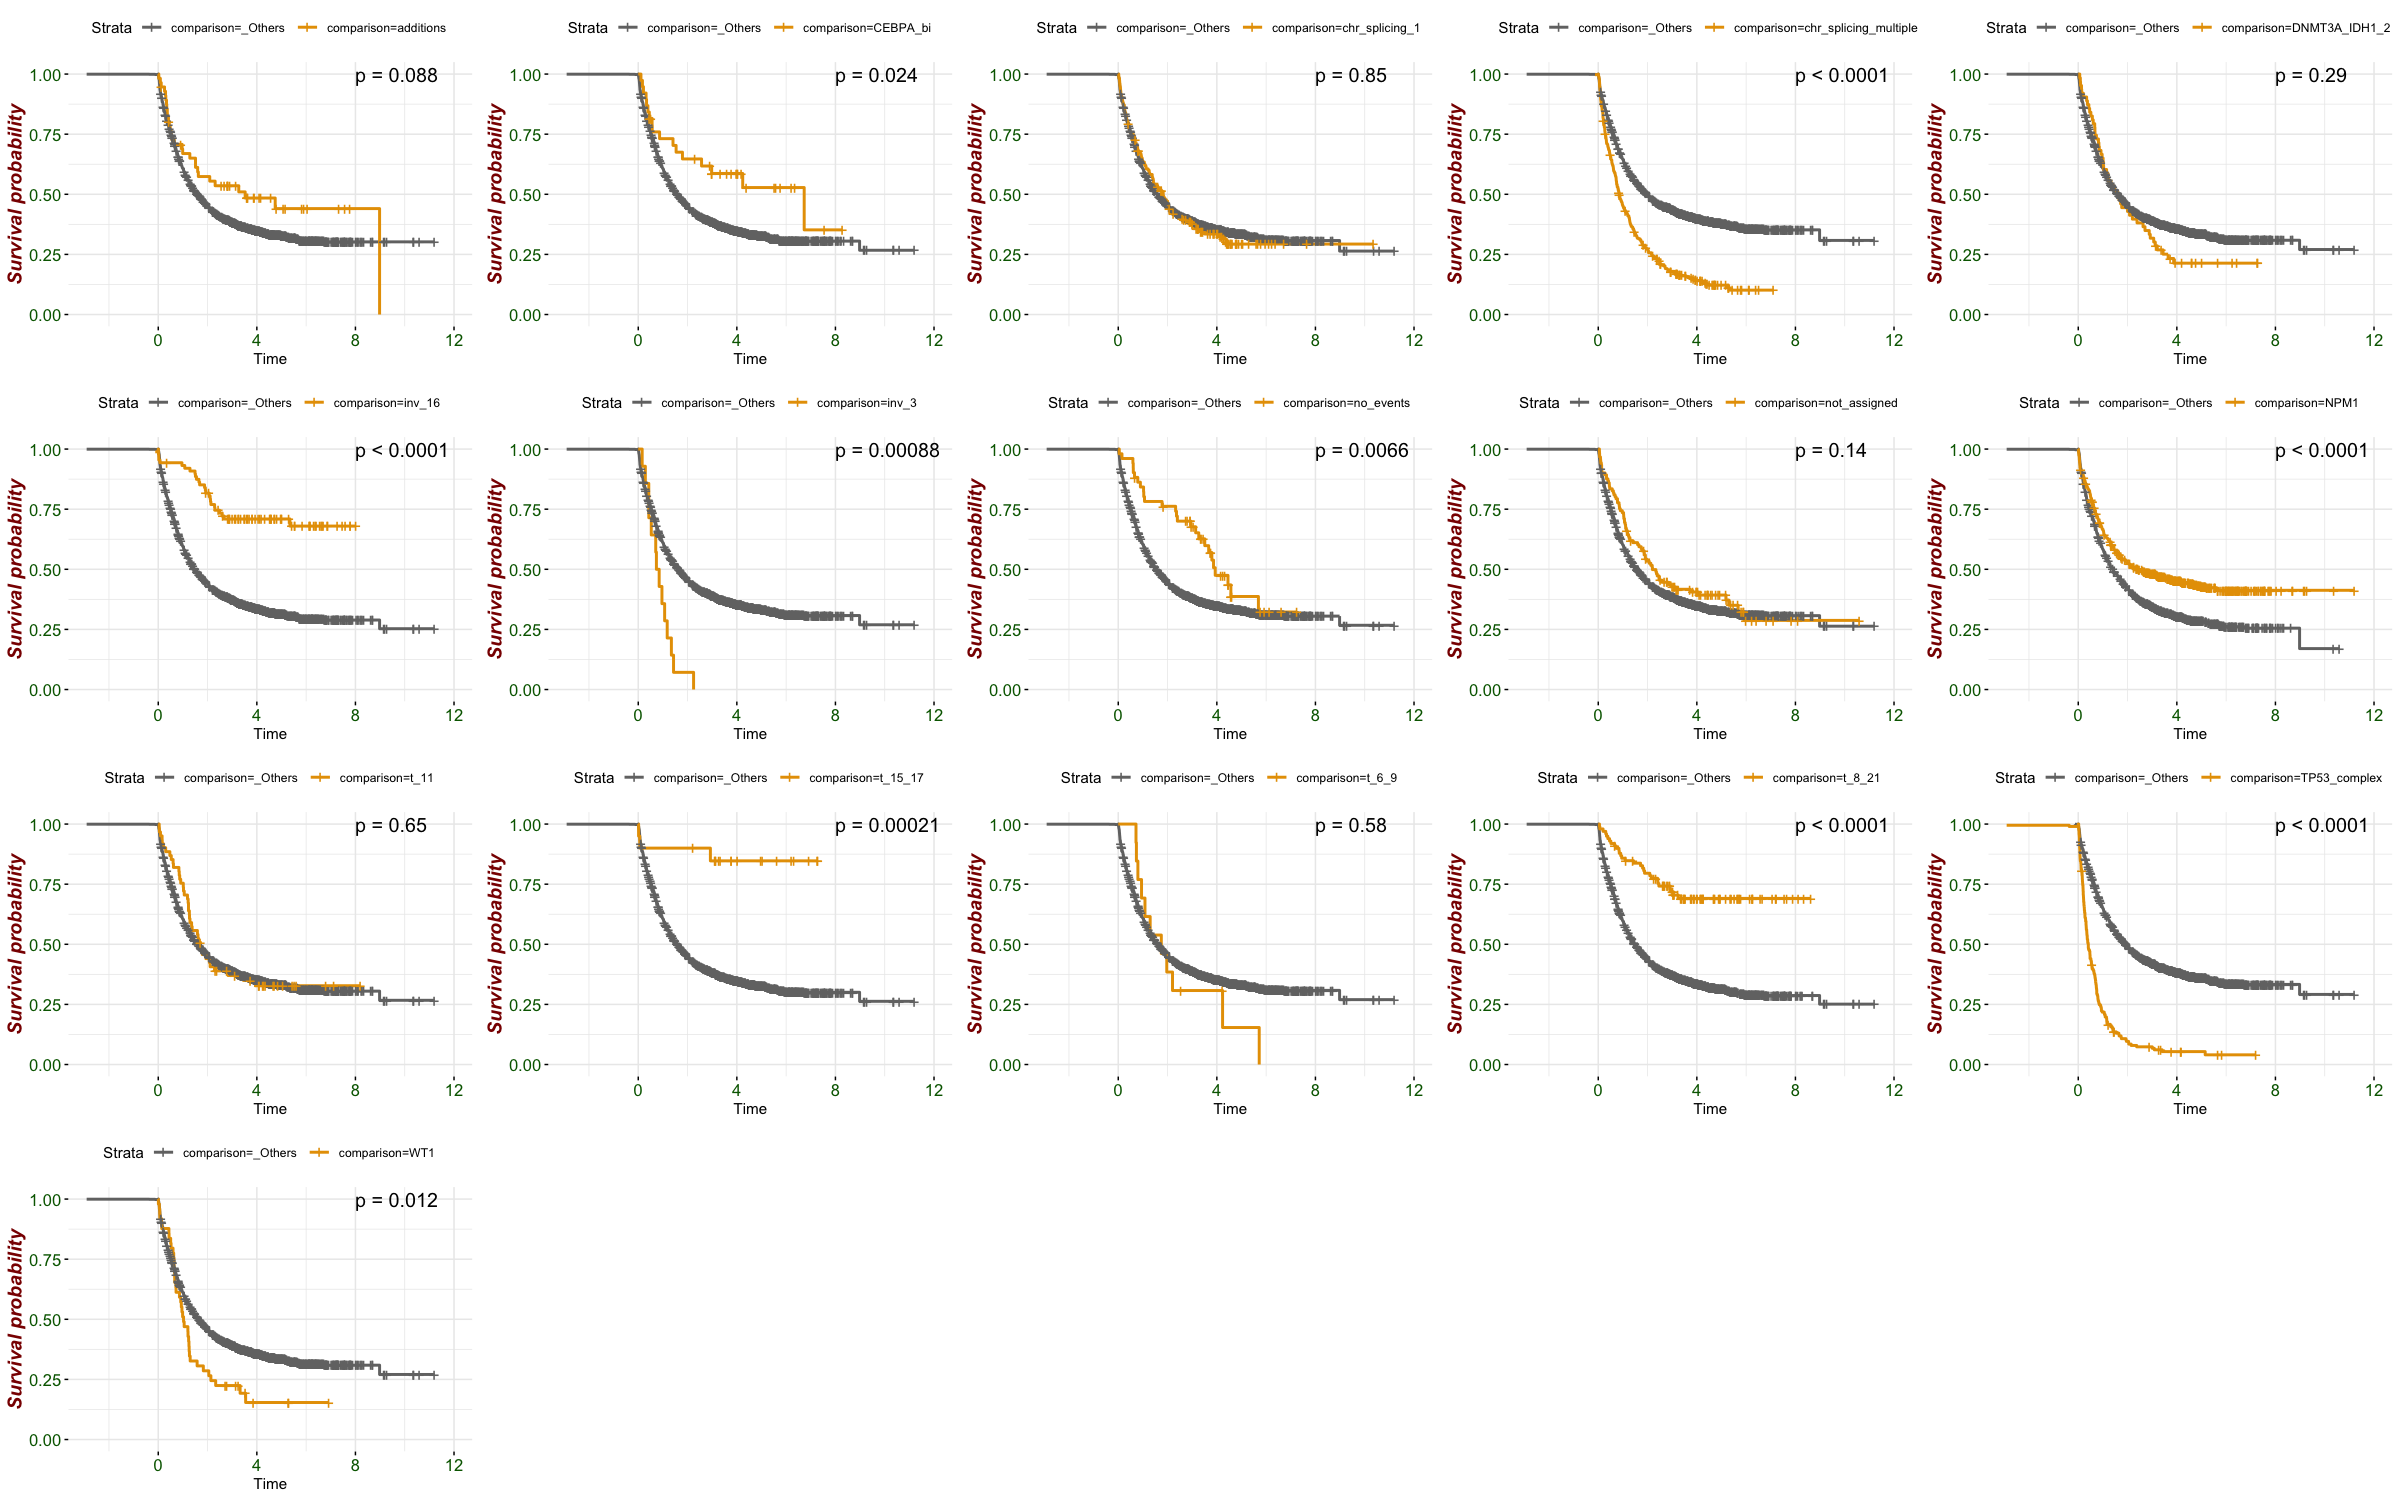

In [46]:
correlates <- c("gender","age","ahd","perf_status","bm_blasts","secondary","wbc","hb","plt","os","cr","os_status")
binary_correlates <- c("gender","ahd","perf_status","secondary","os_status","cr")
continuous_correlates <- c("age","wbc","hb","plt","bm_blasts","os")
val=c("grey45", "#e79f00", "#009E73","#0072B2",  "#CC79A7",
                                      "#9ad0f3", "#D55E00","lightskyblue","mistyrose4", 
                                      "darkseagreen","lightgoldenrod","lightsalmon","#F0E442",
                                      "firebrick3","#000000","#870C14","#a6bddb","#fdbb84","deeppink")
plot_surv <-function(df_surv,title="",width=15,heightDetailsht=6,vals=val){
    set_notebook_plot_size(width,height)
    surv_object <- Surv(time = df_surv$os, event = df_surv$os_status)
    fit1 <- survfit(surv_object ~ comparison, data = df_surv)
    ggsurvplot(fit1, data = df_surv, pval = TRUE,risk.table = TRUE,ggtheme = theme_minimal(),
    risk.table.y.text.col = T,
    risk.table.y.text = T,break.time.by = 1,title= title,palette=as.vector(vals[1:length(unique(df_surv$comparison))]))
}
df_initial <- read.table("../../../data/initial_dataset/Master_04_10_2019.csv",sep = ',' , header = T) 
rownames(df_initial) <- df_initial$data_pd
df_initial <- df_initial[,-1:-4]
df_w_correlates <- merge(df_initial[correlates],df_final_with_comp['final_component'],by=0)
rownames(df_w_correlates) <- df_w_correlates$Row.names
df_w_correlates <- df_w_correlates [,-1]
set_notebook_plot_size(24,15)
list_component <- levels(factor(df_w_correlates$final_component))
survlist <- list()
for (i in list_component){
tmp <- df_w_correlates
tmp$comparison <- ifelse((tmp$final_component==i),i,"_Others") 
surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
survlist[[i]]<-ggsurvplot(fit, data = tmp, pval = TRUE,ggtheme = theme_minimal(),main = "Survival curve",
   font.main = c(16, "bold", "darkblue"),
   font.y = c(14, "bold.italic", "darkred"),  
   palette = c("grey45","#e79f00"),
   pval.coord=c(8,1),
   font.tickslab = c(12, "plain", "darkgreen"))$plot
}
grid.arrange(grobs=survlist,ncol=5)

### STOP .
### LET'S LOOK AT THE SEPARATION OF NOT ASSIGNED


In [ ]:
h <- df_final_with_comp

h[h$final_component=="not_assigned" & (rowSums(h[,1:154])==1) ,]$final_component <- "not_assigned_1_Event"
h[h$final_component=="not_assigned" & (rowSums(h[,1:154])==2) ,]$final_component <- "not_assigned_2_Events"
h[h$final_component=="not_assigned" & (rowSums(h[,1:154])>=3) ,]$final_component <- "not_assigned_3++Events"
table(h$final_component)
h$final_component_numeric <- ifelse(h$final_component=="NPM1",1,
                                              ifelse(h$final_component=="TP53_complex",2, 
                                              ifelse(h$final_component=="t_8_21",3,
                                              ifelse(h$final_component=="inv_16",4, 
                                              ifelse(h$final_component=="CEBPA_bi",5,
                                              ifelse(h$final_component=="t_11",6,
                                              ifelse(h$final_component=="t_15_17",7,
                                              ifelse(h$final_component=="additions",8  ,
                                              ifelse(h$final_component=="inv_3",9,                                               
                                              ifelse(h$final_component=="chr_splicing_multiple",10,
                                              ifelse(h$final_component=="chr_splicing_1",11, 
                                              ifelse(h$final_component=="DNMT3A_IDH1_2",12,
                                              ifelse(h$final_component=="t_6_9",13,
                                              ifelse(h$final_component=="WT1",14,
                                              ifelse(h$final_component=="not_assigned_1_Event",15,
                                              ifelse(h$final_component=="not_assigned_2_Events",16,
                                              ifelse(h$final_component=="not_assigned_3++Events",17,       
                                              18)))))))))))))))))

cols_to_keep = c(1:154,156)
tmp_all <- h[,cols_to_keep][order(h[,cols_to_keep]$final_component_numeric),]
transp_df_all <-(as.data.frame(t(tmp_all)))
transp_df_all$features <- rownames(transp_df_all)
transp_df_all <- transp_df_all[! row.names(transp_df_all) == "final_component_numeric",]
melt.data_all<-melt(transp_df_all,id.vars ="features", variable_name=colnames(transp_df_all))
options(repr.plot.res = 200)
set_notebook_plot_size(12, 18)
col_sep <- tabulate(h[,cols_to_keep]$final_component_numeric)   ## to separate by component

cat("Order of Components :","\n")
cat(paste(unique(h[order(h[,cols_to_keep]$final_component_numeric),]$final_component)," ,"))
# plot the heatmap
ggplot(melt.data_all, aes(variable,features)) +
geom_raster(aes(fill = factor(value)), show.legend = FALSE) +
scale_fill_manual(values = c("0" = "grey45", "1" = "#e79f00")) +
geom_vline(xintercept = cumsum(col_sep)[1:9] + 0.5, col = "#009E73", linetype = 1, size = 0.5) +
geom_vline(xintercept = cumsum(col_sep)[10:18] + 0.5, col = "#CC79A7", linetype = 1, size = 0.3) +
labs(x = 'patients') 


correlates <- c("gender","age","ahd","perf_status","bm_blasts","secondary","wbc","hb","plt","os","cr","os_status")
binary_correlates <- c("gender","ahd","perf_status","secondary","os_status","cr")
continuous_correlates <- c("age","wbc","hb","plt","bm_blasts","os")
val=c("grey45", "#e79f00", "#009E73","#0072B2",  "#CC79A7",
                                      "#9ad0f3", "#D55E00","lightskyblue","mistyrose4", 
                                      "darkseagreen","lightgoldenrod","lightsalmon","#F0E442",
                                      "firebrick3","#000000","#870C14","#a6bddb","#fdbb84","deeppink")
plot_surv <-function(df_surv,title="",width=15,heightDetailsht=6,vals=val){
    set_notebook_plot_size(width,height)
    surv_object <- Surv(time = df_surv$os, event = df_surv$os_status)
    fit1 <- survfit(surv_object ~ comparison, data = df_surv)
    ggsurvplot(fit1, data = df_surv, pval = TRUE,risk.table = TRUE,ggtheme = theme_minimal(),
    risk.table.y.text.col = T,
    risk.table.y.text = T,break.time.by = 1,title= title,palette=as.vector(vals[1:length(unique(df_surv$comparison))]))
}
df_initial <- read.table("../../../data/initial_dataset/Master_04_10_2019.csv",sep = ',' , header = T) 
rownames(df_initial) <- df_initial$data_pd
df_initial <- df_initial[,-1:-4]
df_w_correlates <- merge(df_initial[correlates],h['final_component'],by=0)
rownames(df_w_correlates) <- df_w_correlates$Row.names
df_w_correlates <- df_w_correlates [,-1]
set_notebook_plot_size(24,15)
list_component <- levels(factor(df_w_correlates$final_component))
survlist <- list()
for (i in list_component){
tmp <- df_w_correlates
tmp$comparison <- ifelse((tmp$final_component==i),i,"_Others") 
surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
survlist[[i]]<-ggsurvplot(fit, data = tmp, pval = TRUE,ggtheme = theme_minimal(),main = "Survival curve",
   font.main = c(16, "bold", "darkblue"),
   font.y = c(14, "bold.italic", "darkred"),  
   palette = c("grey45","#e79f00"),
   pval.coord=c(8,1),
   font.tickslab = c(12, "plain", "darkgreen"))$plot
}
set_notebook_plot_size(30,10)
grid.arrange(grobs=survlist,ncol=6)

In [ ]:
TO DO FINALIZE NOT ASSIGNED , WT1 ADD ALL OTHER DEFINING FEATURES IN DUMMY FORM ONE VARIABLE FOR MAIN COMPONENT AND ANOTHER ONE AS DUMMY SUMMING UP ALL OTHERS.
INTERESTING FOR NOT ASSIGNED : THE MORE EVENTS THE BETTER THEY DO IN TERMS OF PROGNOSIS